In [1]:
# Basics libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classification ML Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):

    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def import_data(csv): 
    
    df = pd.read_csv(csv)
    df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.drop('date', axis=1)
    
    close_columns = []
    high_columns = []
    low_columns = []
    open_columns = []
    volume_columns = []
    open_int_columns = []

    for i in df.columns:
        if "close" in i:
            close_columns.append(i)
        elif "high" in i:
            high_columns.append(i)
        elif "low" in i:
            low_columns.append(i)
        elif "open_int" in i:
            open_int_columns.append(i)
        elif "open" in i:
            open_columns.append(i)
        elif "volume" in i:
            volume_columns.append(i)

    close_df = df[close_columns]
    high_df = df[high_columns]
    low_df = df[low_columns]
    open_df = df[open_columns]
    volume_df = df[volume_columns]
    open_int_df = df[open_int_columns]
    
    return [close_df, high_df, low_df, open_df, volume_df, open_int_df]

def garman_klass_vol(high_df, low_df, close_df, open_df, period=60):
    """
    Estima a volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento
    """
    # Calculando parcelas internas da somatoria
    x_hl = (1/2)*(np.log(np.divide(high_df, low_df))) ** 2
    x_co = - (2 * np.log(2) - 1)* (np.log(np.divide(close_df, open_df))**2)
    
    # Somando parcelas calculadas
    x = x_hl + x_co.values
    
    x.columns = [x[0:3] + "gk" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    gk = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1/period
    
    # Atribuindo not a number, para os valores iniciais
    gk.iloc[:period,:] = np.nan
    
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        gk.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return gk

def parkinson_vol(high_df, low_df, period=60):
    """
    Estimando a volatilidade a partir dos preço de Alta e de Baixa
    """
    
    # Calculando parcela interna da somatoria
    x = np.log(np.divide(high_df, low_df)) ** 2
    x.columns = [x[0:3] + "pv" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    pv = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1 / (4 * period * np.log(2))
    
    # Atribuindo not a number, para os valores iniciais
    pv.iloc[:period,:] = np.nan
        
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        pv.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return pv

def monthly_volume(volume, period=20):
    
    daily_volume = volume.copy()
    
    for row in range(period, len(volume)):
        daily_volume.iloc[row] = volume.iloc[row-period:row,:].cumsum().iloc[-1]
        
    monthly_volume = daily_volume.resample("BM").last().ffill()
    
    return monthly_volume
    

In [3]:
close_df, high_df, low_df, open_df, volume_df, open_int_df = import_data("../data.csv")

# Retornos diários
returns_daily = close_df.pct_change().fillna(0)

# Retornos mensais
returns_monthly = close_df.pct_change(20).fillna(0).resample('BM').last().ffill()

# Vol diária
vol_daily = returns_daily.ewm(adjust=True, com=60, min_periods=0).std().dropna()

# Vol de 261 dias, apenas o último dia de cada mês
vol_monthly = (np.sqrt(261)*vol_daily).resample('BM').last().ffill()

pv_df = parkinson_vol(high_df, low_df)
pv_monthly = (np.sqrt(261)*pv_df).resample('BM').last().ffill()

gk_df = garman_klass_vol(high_df, low_df, close_df, open_df)
gk_monthly = (np.sqrt(261)*gk_df).resample('BM').last().ffill()

monthly_volume = monthly_volume(volume_df)

## Feature Engineering

In [4]:
def train_test(stock):
    train = pd.DataFrame()

    train["Returns Monthly"] = returns_monthly.iloc[:,stock]
    train["EWMA"] = vol_monthly.iloc[:,stock]
    train["Parkinson"] = pv_monthly.iloc[:,stock]
    train["Garman-Klass"] = gk_monthly.iloc[:,stock]
    train["Monthly Volume"] = monthly_volume.iloc[:,stock]

    prices = close_df.iloc[:,stock]

    for lag in [3, 6, 9, 12]:
        train["Momentum " + str(lag)] = prices.pct_change(lag * 21)

    target = train["Returns Monthly"].shift(-1)
    
    features = train.dropna()
    target = target.dropna().loc['2000-07-31':]
    
    return (features, target)

# Visualization


In [5]:
features, target = train_test(1)
df = features
df["target"] = np.sign(target)

In [6]:
features.head()

,Returns Monthly,EWMA,Parkinson,Garman-Klass,Monthly Volume,Momentum 3,Momentum 6,Momentum 9,Momentum 12,target
date,,,,,,,,,,
2000-07-31,-0.013500,0.081672,0.090117,0.087723,135249.0,-0.051498,-0.084389,-0.095780,-0.052628,-1.0
2000-08-31,-0.031493,0.076585,0.078957,0.080442,137686.0,-0.025209,-0.094248,-0.106080,-0.107423,1.0
2000-09-29,0.010879,0.095101,0.092941,0.094567,227772.0,-0.017524,-0.063966,-0.096061,-0.084917,-1.0
2000-10-31,-0.010391,0.097895,0.104744,0.107019,101142.0,-0.045012,-0.090034,-0.116647,-0.124354,-1.0
2000-11-30,-0.019273,0.092711,0.111326,0.112521,92974.0,-0.043417,-0.050007,-0.119602,-0.133054,1.0


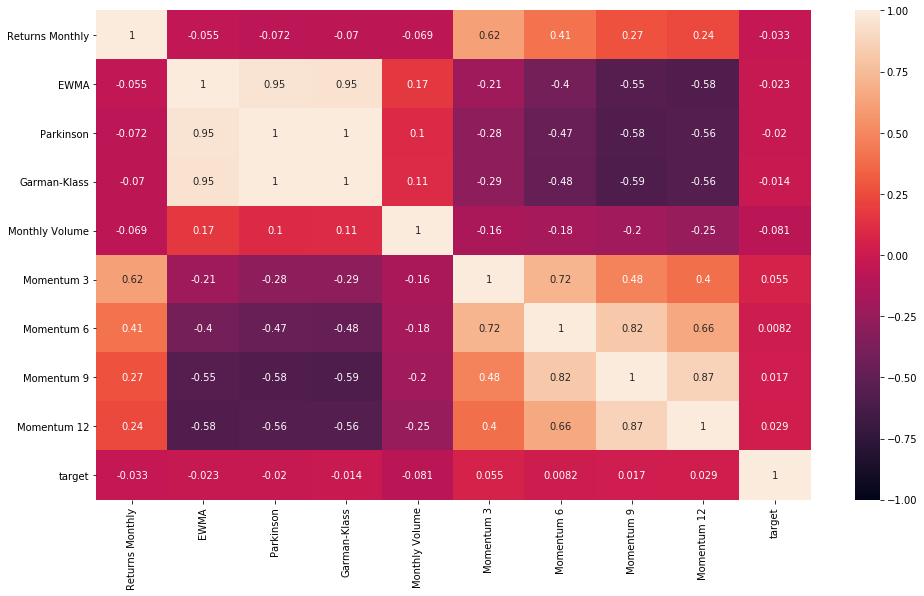

In [7]:
plt.figure(figsize=(16,9))
sns.heatmap(features.corr(), annot=True, vmin=-1, vmax=1)

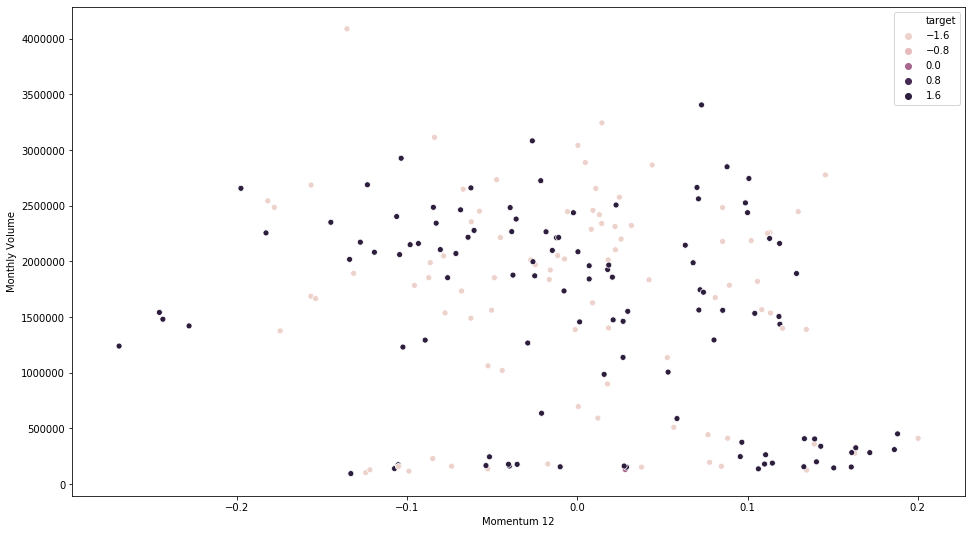

In [8]:
plt.figure(figsize=(16,9))
sns.scatterplot('Momentum 12', 'Monthly Volume',
                hue='target',  data=df)

## Trainning

In [9]:
def backtesting(model, name="MODEL"):
    momentum = []
    prediction = []
    real = []

    for stock in range(54):

        printProgressBar(stock, 53)

        features, target = train_test(stock)

        pred = []
        true = []
        mom = []
        
        start=100
        end=189

        for date in range(start ,end):
            
            # **TRAIN DATA**
            # Features
            X = features.iloc[:date]
            
            # Target
            y = np.sign(target.iloc[:date])

            # **TEST DATA**
            # Features
            X_test = features.iloc[date:date+1]
            
            # Target
            y_test = np.sign(target.iloc[date:date+1])

            # Fitting the model
            model.fit(X, y)

            y_pred = model.predict(X_test)

            pred.append(y_pred[0])
            true.append(y_test[0])
            mom.append(np.sign(features["Momentum 12"].iloc[date]))
            
        #print(accuracy_score(mom, true))

        momentum.append(mom)
        prediction.append(pred)
        real.append(true)

    mom_array = np.array(momentum)
    pred_array = np.array(prediction)
    real_array = np.array(real)
    
    months = end - start
    # Reshaping
    true = real_array.reshape((54*months, 1))
    pred = pred_array.reshape((54*months, 1))
    mom = mom_array.reshape((54*months, 1))

    model_ac = accuracy_score(true, pred)

    mom_ac = accuracy_score(true, mom)

    print("MOMENTUM")
    print( "Accuracy: ", mom_ac)
    print()
    print(name)
    print("Accuracy: ", model_ac)

In [13]:
backtesting(SVC())

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5278818143986683

MODEL
Accuracy:  0.5430711610486891


In [18]:
backtesting(RidgeClassifier())

/Users/taqtile/opt/anaconda3/envs/momentum_env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02519e-16): result may not be accurate.
  overwrite_a=True).T
/Users/taqtile/opt/anaconda3/envs/momentum_env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.83172e-17): result may not be accurate.
  overwrite_a=True).T
/Users/taqtile/opt/anaconda3/envs/momentum_env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00172e-16): result may not be accurate.
  overwrite_a=True).T
/Users/taqtile/opt/anaconda3/envs/momentum_env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02999e-16): result may not be accurate.
  overwrite_a=True).T
/Users/taqtile/opt/anaconda3/envs/momentum_env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWar

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5278818143986683

MODEL
Accuracy:  0.5441115272575947


In [33]:
backtesting(SGDClassifier())

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5345679012345679

MODEL
Accuracy:  0.5172839506172839


In [11]:
backtesting(MLPClassifier(solver='lbfgs', 
                          alpha=1e-3, 
                          activation='relu',
                          hidden_layer_sizes=(5, 3), 
                          random_state=1),
           )

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5278818143986683

MODEL
Accuracy:  0.5532667498959634


In [50]:
backtesting(MLPClassifier(solver='lbfgs', 
                          alpha=1e-3, 
                          activation='logistic',
                          hidden_layer_sizes=(7, 3), 
                          random_state=1),
           )

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5345679012345679

MODEL
Accuracy:  0.5621399176954732


In [35]:
backtesting(RandomForestClassifier())

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
MOMENTUM
Accuracy:  0.5345679012345679

MODEL
Accuracy:  0.5325102880658437


In [188]:
def timeseries_to_supervised(data, lag=12):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

In [260]:
X = []
y = []

for column in close_df.columns:
    X.append(timeseries_to_supervised(close_df[column]['2000-07-08':]).fillna(0).to_numpy())
    y.append(close_df[column]['2000-07-07':].shift(1).dropna().to_numpy())
    
X = np.array(X)
y = np.array(y)

X = X.reshape((236034, 13))
y = y.reshape((236034, 1))

In [261]:
X.shape

(236034, 13)

In [262]:
y.shape

(236034, 1)

In [263]:
split_time = 20000

# X = tf.keras.utils.normalize(X)
# y = tf.keras.utils.normalize(y)

X_train = X[split_time:]
y_train = y[split_time:]

X_test = X[:split_time]
y_test = y[:split_time]

In [318]:
import keras
from keras import Sequential
from keras.layers import LSTM, Dense, Lambda, Conv2D, MaxPooling2D, Flatten
import tensorflow as tf

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 94983449984363597
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4134710611942619240
physical_device_desc: "device: XLA_CPU device"
]


In [272]:
model = Sequential()

units = 7

model.add(keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))

model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='relu'))

model.add(Dense(1))

In [273]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam')

In [274]:
model.fit(X_train, y_train, epochs=6)

Epoch 1/6
216034/216034 [==============================] - 123s 567us/step - loss: 684.8310
Epoch 2/6
216034/216034 [==============================] - 124s 573us/step - loss: 649.9574
Epoch 3/6
216034/216034 [==============================] - 125s 579us/step - loss: 753.8031
Epoch 4/6
216034/216034 [==============================] - 112s 520us/step - loss: 524.3887
Epoch 5/6
216034/216034 [==============================] - 112s 520us/step - loss: 591.2479
Epoch 6/6
216034/216034 [==============================] - 103s 477us/step - loss: 316.2880


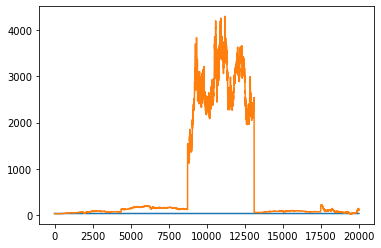

In [268]:
plt.plot(model.predict(X_test))
plt.plot(y_test)

In [269]:
from sklearn.metrics import mean_squared_error
mean_squared_error(model.predict(X_test), y_test)

1686987.4244774657

In [270]:
model.predict(X_test)

array([[40.236317],
       [40.236317],
       [40.236317],
       ...,
       [40.236317],
       [40.236317],
       [40.236317]], dtype=float32)

In [271]:
tf.keras.utils.normalize(X)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.71002566, 0.        , 0.        , ..., 0.        , 0.        ,
        0.70417581],
       [0.57545425, 0.58023477, 0.        , ..., 0.        , 0.        ,
        0.5763506 ],
       ...,
       [0.28373919, 0.27822399, 0.2786385 , ..., 0.27000761, 0.26906577,
        0.28319804],
       [0.28198318, 0.28252201, 0.27703047, ..., 0.27453578, 0.26884934,
        0.28343918],
       [0.28247015, 0.28101912, 0.28155612, ..., 0.27351721, 0.27359719,
        0.2803793 ]])

In [282]:
from pandas_datareader import data

ibm = data.DataReader("IBM", data_source='yahoo')

In [283]:
ibm

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-27,160.179993,158.600006,159.000000,159.070007,3706200.0,127.988770
2015-07-28,160.190002,158.500000,159.910004,160.050003,2721000.0,128.777283
2015-07-29,161.500000,159.389999,160.000000,161.089996,3378400.0,129.614075
2015-07-30,161.399994,159.750000,160.500000,160.960007,1994700.0,129.509445
2015-07-31,162.059998,160.630005,161.399994,161.990005,3580200.0,130.338211
...,...,...,...,...,...,...
2020-07-20,127.070000,125.139999,126.070000,126.370003,9927700.0,126.370003
2020-07-21,132.169998,125.800003,131.160004,126.059998,15364900.0,126.059998
2020-07-22,129.470001,125.800003,125.900002,128.669998,8195400.0,128.669998


In [310]:
def feature_target_matrix(data, window=20, offset=30):
    X = []
    y = []
    for i in range(offset,len(data)):
        X.append(data[i-window:i].to_numpy())
        y.append(data['Close'][i])
        
    X = np.array(X)
    y = np.array(y)
    
    return (X, y)

In [311]:
X, y = feature_target_matrix(ibm)

In [314]:
X.shape

(1229, 20, 6)

In [295]:
y.shape

(1229,)

In [329]:
split = 700

X = X.reshape((1229, 20, 6, 1))

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

In [352]:

model = Sequential()

model.add(Conv2D(20, 2, input_shape=(20, 6, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())

model.add(LSTM(32))

model.add(Dense(90, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

ValueError: Input 0 is incompatible with layer lstm_69: expected ndim=3, found ndim=2

In [ ]:
model.compile(loss='mse', optimizer='adam')
model.summary()

In [349]:
model.fit(X_train, y_train, epochs=100000)

Epoch 1/100000
700/700 [==============================] - 0s 55us/step - loss: 5.9662
Epoch 2/100000
700/700 [==============================] - 0s 55us/step - loss: 6.0788
Epoch 3/100000
700/700 [==============================] - 0s 54us/step - loss: 6.4500
Epoch 4/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4470
Epoch 5/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3492
Epoch 6/100000
700/700 [==============================] - 0s 63us/step - loss: 6.3517
Epoch 7/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8352
Epoch 8/100000
700/700 [==============================] - 0s 55us/step - loss: 6.5817
Epoch 9/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1460
Epoch 10/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0404
Epoch 11/100000
700/700 [==============================] - 0s 57us/step - loss: 6.2622
Epoch 12/100000
700/700 [===========================

700/700 [==============================] - 0s 64us/step - loss: 6.5670
Epoch 96/100000
700/700 [==============================] - 0s 64us/step - loss: 6.2897
Epoch 97/100000
700/700 [==============================] - 0s 62us/step - loss: 6.1064
Epoch 98/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0624
Epoch 99/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0383
Epoch 100/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0974
Epoch 101/100000
700/700 [==============================] - 0s 62us/step - loss: 6.6213
Epoch 102/100000
700/700 [==============================] - 0s 62us/step - loss: 6.1515
Epoch 103/100000
700/700 [==============================] - 0s 65us/step - loss: 6.5935
Epoch 104/100000
700/700 [==============================] - 0s 61us/step - loss: 7.4576
Epoch 105/100000
700/700 [==============================] - 0s 61us/step - loss: 6.4276
Epoch 106/100000
700/700 [===========================

700/700 [==============================] - 0s 59us/step - loss: 6.2317
Epoch 189/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0684
Epoch 190/100000
700/700 [==============================] - 0s 58us/step - loss: 6.8738
Epoch 191/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8882
Epoch 192/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9935
Epoch 193/100000
700/700 [==============================] - 0s 58us/step - loss: 6.4752
Epoch 194/100000
700/700 [==============================] - 0s 57us/step - loss: 7.7205
Epoch 195/100000
700/700 [==============================] - 0s 57us/step - loss: 6.7752
Epoch 196/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5803
Epoch 197/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8395
Epoch 198/100000
700/700 [==============================] - 0s 57us/step - loss: 6.2961
Epoch 199/100000
700/700 [=======================

700/700 [==============================] - 0s 59us/step - loss: 6.0864
Epoch 282/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1937
Epoch 283/100000
700/700 [==============================] - 0s 57us/step - loss: 6.4356
Epoch 284/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0154
Epoch 285/100000
700/700 [==============================] - 0s 56us/step - loss: 6.0510
Epoch 286/100000
700/700 [==============================] - 0s 58us/step - loss: 6.4529
Epoch 287/100000
700/700 [==============================] - 0s 57us/step - loss: 69.4312
Epoch 288/100000
700/700 [==============================] - 0s 59us/step - loss: 10.9971
Epoch 289/100000
700/700 [==============================] - 0s 54us/step - loss: 6.6296
Epoch 290/100000
700/700 [==============================] - 0s 55us/step - loss: 6.0275
Epoch 291/100000
700/700 [==============================] - 0s 56us/step - loss: 5.9964
Epoch 292/100000
700/700 [=====================

700/700 [==============================] - 0s 56us/step - loss: 6.2741
Epoch 375/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9133
Epoch 376/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9194
Epoch 377/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0851
Epoch 378/100000
700/700 [==============================] - 0s 57us/step - loss: 6.2676
Epoch 379/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9254
Epoch 380/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1940
Epoch 381/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0959
Epoch 382/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1969
Epoch 383/100000
700/700 [==============================] - 0s 57us/step - loss: 7.2145
Epoch 384/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1143
Epoch 385/100000
700/700 [=======================

700/700 [==============================] - 0s 55us/step - loss: 6.4054
Epoch 468/100000
700/700 [==============================] - 0s 56us/step - loss: 6.0009
Epoch 469/100000
700/700 [==============================] - 0s 57us/step - loss: 5.8343
Epoch 470/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8638
Epoch 471/100000
700/700 [==============================] - 0s 55us/step - loss: 6.1181
Epoch 472/100000
700/700 [==============================] - 0s 55us/step - loss: 7.1116
Epoch 473/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9691
Epoch 474/100000
700/700 [==============================] - 0s 56us/step - loss: 6.7858
Epoch 475/100000
700/700 [==============================] - 0s 57us/step - loss: 7.2859
Epoch 476/100000
700/700 [==============================] - 0s 56us/step - loss: 6.7355
Epoch 477/100000
700/700 [==============================] - 0s 56us/step - loss: 6.1054
Epoch 478/100000
700/700 [=======================

700/700 [==============================] - 0s 56us/step - loss: 6.0030
Epoch 561/100000
700/700 [==============================] - 0s 56us/step - loss: 6.3966
Epoch 562/100000
700/700 [==============================] - 0s 55us/step - loss: 5.8866
Epoch 563/100000
700/700 [==============================] - 0s 54us/step - loss: 5.9554
Epoch 564/100000
700/700 [==============================] - 0s 56us/step - loss: 5.6733
Epoch 565/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8648
Epoch 566/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8520
Epoch 567/100000
700/700 [==============================] - 0s 54us/step - loss: 6.3405
Epoch 568/100000
700/700 [==============================] - 0s 56us/step - loss: 7.0598
Epoch 569/100000
700/700 [==============================] - 0s 56us/step - loss: 5.9908
Epoch 570/100000
700/700 [==============================] - 0s 56us/step - loss: 6.4027
Epoch 571/100000
700/700 [=======================

700/700 [==============================] - 0s 56us/step - loss: 5.7005
Epoch 654/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1091
Epoch 655/100000
700/700 [==============================] - 0s 56us/step - loss: 5.7977
Epoch 656/100000
700/700 [==============================] - 0s 57us/step - loss: 5.6944
Epoch 657/100000
700/700 [==============================] - 0s 55us/step - loss: 5.7046
Epoch 658/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8037
Epoch 659/100000
700/700 [==============================] - 0s 57us/step - loss: 9.5573
Epoch 660/100000
700/700 [==============================] - 0s 56us/step - loss: 6.0043
Epoch 661/100000
700/700 [==============================] - 0s 56us/step - loss: 6.0046
Epoch 662/100000
700/700 [==============================] - 0s 55us/step - loss: 6.1591
Epoch 663/100000
700/700 [==============================] - 0s 55us/step - loss: 6.3541
Epoch 664/100000
700/700 [=======================

700/700 [==============================] - 0s 57us/step - loss: 5.8152
Epoch 747/100000
700/700 [==============================] - 0s 56us/step - loss: 5.9422
Epoch 748/100000
700/700 [==============================] - 0s 59us/step - loss: 6.5977
Epoch 749/100000
700/700 [==============================] - 0s 57us/step - loss: 6.2600
Epoch 750/100000
700/700 [==============================] - 0s 55us/step - loss: 6.2209
Epoch 751/100000
700/700 [==============================] - 0s 55us/step - loss: 5.6732
Epoch 752/100000
700/700 [==============================] - 0s 57us/step - loss: 6.2147
Epoch 753/100000
700/700 [==============================] - 0s 55us/step - loss: 5.8828
Epoch 754/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6464
Epoch 755/100000
700/700 [==============================] - 0s 56us/step - loss: 5.6011
Epoch 756/100000
700/700 [==============================] - 0s 57us/step - loss: 5.8337
Epoch 757/100000
700/700 [=======================

700/700 [==============================] - 0s 58us/step - loss: 6.2142
Epoch 840/100000
700/700 [==============================] - 0s 56us/step - loss: 6.1767
Epoch 841/100000
700/700 [==============================] - 0s 56us/step - loss: 6.5992
Epoch 842/100000
700/700 [==============================] - 0s 57us/step - loss: 5.5715
Epoch 843/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0010
Epoch 844/100000
700/700 [==============================] - 0s 57us/step - loss: 5.7823
Epoch 845/100000
700/700 [==============================] - 0s 57us/step - loss: 5.8576
Epoch 846/100000
700/700 [==============================] - 0s 57us/step - loss: 6.8955
Epoch 847/100000
700/700 [==============================] - 0s 59us/step - loss: 6.9184
Epoch 848/100000
700/700 [==============================] - 0s 55us/step - loss: 6.1110
Epoch 849/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6055
Epoch 850/100000
700/700 [=======================

700/700 [==============================] - 0s 57us/step - loss: 6.1273
Epoch 933/100000
700/700 [==============================] - 0s 56us/step - loss: 5.9485
Epoch 934/100000
700/700 [==============================] - 0s 56us/step - loss: 6.4010
Epoch 935/100000
700/700 [==============================] - 0s 57us/step - loss: 5.7809
Epoch 936/100000
700/700 [==============================] - 0s 57us/step - loss: 6.4769
Epoch 937/100000
700/700 [==============================] - 0s 57us/step - loss: 7.1385
Epoch 938/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1412
Epoch 939/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0078
Epoch 940/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6104
Epoch 941/100000
700/700 [==============================] - 0s 63us/step - loss: 6.2116
Epoch 942/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3175
Epoch 943/100000
700/700 [=======================

700/700 [==============================] - 0s 59us/step - loss: 6.2226
Epoch 1026/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8836
Epoch 1027/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8482
Epoch 1028/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6309
Epoch 1029/100000
700/700 [==============================] - 0s 57us/step - loss: 5.5627
Epoch 1030/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4381
Epoch 1031/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0473
Epoch 1032/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6658
Epoch 1033/100000
700/700 [==============================] - 0s 57us/step - loss: 5.4559
Epoch 1034/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9277
Epoch 1035/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6800
Epoch 1036/100000
700/700 [============

700/700 [==============================] - 0s 55us/step - loss: 5.8791
Epoch 1118/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6408
Epoch 1119/100000
700/700 [==============================] - 0s 57us/step - loss: 5.5859
Epoch 1120/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5523
Epoch 1121/100000
700/700 [==============================] - 0s 59us/step - loss: 5.4791
Epoch 1122/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4900
Epoch 1123/100000
700/700 [==============================] - 0s 57us/step - loss: 5.6305
Epoch 1124/100000
700/700 [==============================] - 0s 57us/step - loss: 5.4482
Epoch 1125/100000
700/700 [==============================] - 0s 57us/step - loss: 334.3556
Epoch 1126/100000
700/700 [==============================] - 0s 59us/step - loss: 13.8712
Epoch 1127/100000
700/700 [==============================] - 0s 57us/step - loss: 10.8242
Epoch 1128/100000
700/700 [========

700/700 [==============================] - 0s 64us/step - loss: 6.3899
Epoch 1210/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3027
Epoch 1211/100000
700/700 [==============================] - 0s 67us/step - loss: 6.7355
Epoch 1212/100000
700/700 [==============================] - 0s 62us/step - loss: 6.8355
Epoch 1213/100000
700/700 [==============================] - 0s 63us/step - loss: 6.5479
Epoch 1214/100000
700/700 [==============================] - 0s 66us/step - loss: 6.5391
Epoch 1215/100000
700/700 [==============================] - 0s 64us/step - loss: 6.3728
Epoch 1216/100000
700/700 [==============================] - 0s 65us/step - loss: 6.1577
Epoch 1217/100000
700/700 [==============================] - 0s 67us/step - loss: 7.0651
Epoch 1218/100000
700/700 [==============================] - 0s 66us/step - loss: 6.7005
Epoch 1219/100000
700/700 [==============================] - 0s 67us/step - loss: 6.6418
Epoch 1220/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.5364
Epoch 1302/100000
700/700 [==============================] - 0s 57us/step - loss: 7.4262
Epoch 1303/100000
700/700 [==============================] - 0s 57us/step - loss: 6.9151
Epoch 1304/100000
700/700 [==============================] - 0s 58us/step - loss: 7.3690
Epoch 1305/100000
700/700 [==============================] - 0s 57us/step - loss: 6.8061
Epoch 1306/100000
700/700 [==============================] - 0s 58us/step - loss: 7.1868
Epoch 1307/100000
700/700 [==============================] - 0s 59us/step - loss: 6.8077
Epoch 1308/100000
700/700 [==============================] - 0s 58us/step - loss: 7.2589
Epoch 1309/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5368
Epoch 1310/100000
700/700 [==============================] - 0s 58us/step - loss: 6.5638
Epoch 1311/100000
700/700 [==============================] - 0s 56us/step - loss: 6.0720
Epoch 1312/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 6.3447
Epoch 1394/100000
700/700 [==============================] - 0s 60us/step - loss: 6.7174
Epoch 1395/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9485
Epoch 1396/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3862
Epoch 1397/100000
700/700 [==============================] - 0s 59us/step - loss: 6.5587
Epoch 1398/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3028
Epoch 1399/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8566
Epoch 1400/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1657
Epoch 1401/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9712
Epoch 1402/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9523
Epoch 1403/100000
700/700 [==============================] - 0s 58us/step - loss: 7.2842
Epoch 1404/100000
700/700 [============

700/700 [==============================] - 0s 65us/step - loss: 15.1456
Epoch 1486/100000
700/700 [==============================] - 0s 59us/step - loss: 11.9138
Epoch 1487/100000
700/700 [==============================] - 0s 56us/step - loss: 11.6081
Epoch 1488/100000
700/700 [==============================] - 0s 55us/step - loss: 11.4828
Epoch 1489/100000
700/700 [==============================] - 0s 58us/step - loss: 11.6518
Epoch 1490/100000
700/700 [==============================] - 0s 58us/step - loss: 11.3938
Epoch 1491/100000
700/700 [==============================] - 0s 58us/step - loss: 11.4716
Epoch 1492/100000
700/700 [==============================] - 0s 56us/step - loss: 11.3929
Epoch 1493/100000
700/700 [==============================] - 0s 57us/step - loss: 11.2836
Epoch 1494/100000
700/700 [==============================] - 0s 58us/step - loss: 11.1801
Epoch 1495/100000
700/700 [==============================] - 0s 58us/step - loss: 11.1380
Epoch 1496/100000
700/700 [=

700/700 [==============================] - 0s 58us/step - loss: 6.9832
Epoch 1577/100000
700/700 [==============================] - 0s 58us/step - loss: 6.8868
Epoch 1578/100000
700/700 [==============================] - 0s 58us/step - loss: 7.1113
Epoch 1579/100000
700/700 [==============================] - 0s 58us/step - loss: 6.6268
Epoch 1580/100000
700/700 [==============================] - 0s 57us/step - loss: 6.6654
Epoch 1581/100000
700/700 [==============================] - 0s 58us/step - loss: 6.7905
Epoch 1582/100000
700/700 [==============================] - 0s 57us/step - loss: 6.8090
Epoch 1583/100000
700/700 [==============================] - 0s 57us/step - loss: 6.9327
Epoch 1584/100000
700/700 [==============================] - 0s 59us/step - loss: 6.8076
Epoch 1585/100000
700/700 [==============================] - 0s 57us/step - loss: 7.3501
Epoch 1586/100000
700/700 [==============================] - 0s 58us/step - loss: 6.9180
Epoch 1587/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 6.2780
Epoch 1669/100000
700/700 [==============================] - 0s 58us/step - loss: 6.4063
Epoch 1670/100000
700/700 [==============================] - 0s 56us/step - loss: 6.5480
Epoch 1671/100000
700/700 [==============================] - 0s 59us/step - loss: 6.5886
Epoch 1672/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3597
Epoch 1673/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3902
Epoch 1674/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3098
Epoch 1675/100000
700/700 [==============================] - 0s 58us/step - loss: 6.7075
Epoch 1676/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5961
Epoch 1677/100000
700/700 [==============================] - 0s 58us/step - loss: 7.0039
Epoch 1678/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5024
Epoch 1679/100000
700/700 [============

700/700 [==============================] - 0s 55us/step - loss: 6.3461
Epoch 1761/100000
700/700 [==============================] - 0s 59us/step - loss: 6.9838
Epoch 1762/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1790
Epoch 1763/100000
700/700 [==============================] - 0s 58us/step - loss: 6.4651
Epoch 1764/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2943
Epoch 1765/100000
700/700 [==============================] - 0s 58us/step - loss: 6.8125
Epoch 1766/100000
700/700 [==============================] - 0s 56us/step - loss: 6.3574
Epoch 1767/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1520
Epoch 1768/100000
700/700 [==============================] - 0s 58us/step - loss: 6.4177
Epoch 1769/100000
700/700 [==============================] - 0s 57us/step - loss: 6.3181
Epoch 1770/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2045
Epoch 1771/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.4410
Epoch 1853/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3172
Epoch 1854/100000
700/700 [==============================] - 0s 58us/step - loss: 7.0062
Epoch 1855/100000
700/700 [==============================] - 0s 61us/step - loss: 7.4092
Epoch 1856/100000
700/700 [==============================] - 0s 60us/step - loss: 6.8039
Epoch 1857/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3397
Epoch 1858/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4725
Epoch 1859/100000
700/700 [==============================] - 0s 59us/step - loss: 6.7694
Epoch 1860/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2456
Epoch 1861/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2739
Epoch 1862/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1716
Epoch 1863/100000
700/700 [============

700/700 [==============================] - 0s 56us/step - loss: 6.4374
Epoch 1945/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0169
Epoch 1946/100000
700/700 [==============================] - 0s 55us/step - loss: 6.1897
Epoch 1947/100000
700/700 [==============================] - 0s 56us/step - loss: 6.4586
Epoch 1948/100000
700/700 [==============================] - 0s 56us/step - loss: 6.7255
Epoch 1949/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2005
Epoch 1950/100000
700/700 [==============================] - 0s 56us/step - loss: 6.3738
Epoch 1951/100000
700/700 [==============================] - 0s 58us/step - loss: 7.2243
Epoch 1952/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4218
Epoch 1953/100000
700/700 [==============================] - 0s 55us/step - loss: 6.5365
Epoch 1954/100000
700/700 [==============================] - 0s 57us/step - loss: 6.2911
Epoch 1955/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.3155
Epoch 2037/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1030
Epoch 2038/100000
700/700 [==============================] - 0s 57us/step - loss: 6.6983
Epoch 2039/100000
700/700 [==============================] - 0s 58us/step - loss: 8.5653
Epoch 2040/100000
700/700 [==============================] - 0s 58us/step - loss: 6.7958
Epoch 2041/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1057
Epoch 2042/100000
700/700 [==============================] - 0s 58us/step - loss: 7.1511
Epoch 2043/100000
700/700 [==============================] - 0s 58us/step - loss: 7.3740
Epoch 2044/100000
700/700 [==============================] - 0s 59us/step - loss: 7.6765
Epoch 2045/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1626
Epoch 2046/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2779
Epoch 2047/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 7.0722
Epoch 2129/100000
700/700 [==============================] - 0s 61us/step - loss: 7.6660
Epoch 2130/100000
700/700 [==============================] - 0s 60us/step - loss: 6.5250
Epoch 2131/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2512
Epoch 2132/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3228
Epoch 2133/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2010
Epoch 2134/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9790
Epoch 2135/100000
700/700 [==============================] - 0s 60us/step - loss: 6.5199
Epoch 2136/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3603
Epoch 2137/100000
700/700 [==============================] - 0s 58us/step - loss: 6.7430
Epoch 2138/100000
700/700 [==============================] - 0s 56us/step - loss: 6.8871
Epoch 2139/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 5.7490
Epoch 2221/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9090
Epoch 2222/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1465
Epoch 2223/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3603
Epoch 2224/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0868
Epoch 2225/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5721
Epoch 2226/100000
700/700 [==============================] - 0s 58us/step - loss: 7.4092
Epoch 2227/100000
700/700 [==============================] - 0s 57us/step - loss: 7.1640
Epoch 2228/100000
700/700 [==============================] - 0s 58us/step - loss: 7.9258
Epoch 2229/100000
700/700 [==============================] - 0s 57us/step - loss: 6.3462
Epoch 2230/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0954
Epoch 2231/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 7.6359
Epoch 2313/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3764
Epoch 2314/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2604
Epoch 2315/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0390
Epoch 2316/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9205
Epoch 2317/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1295
Epoch 2318/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9903
Epoch 2319/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0665
Epoch 2320/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3977
Epoch 2321/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3711
Epoch 2322/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2401
Epoch 2323/100000
700/700 [============

Epoch 2404/100000
700/700 [==============================] - 0s 55us/step - loss: 6.2646
Epoch 2405/100000
700/700 [==============================] - 0s 56us/step - loss: 6.3734
Epoch 2406/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8911
Epoch 2407/100000
700/700 [==============================] - 0s 56us/step - loss: 6.9845
Epoch 2408/100000
700/700 [==============================] - 0s 59us/step - loss: 6.7380
Epoch 2409/100000
700/700 [==============================] - 0s 58us/step - loss: 6.8238
Epoch 2410/100000
700/700 [==============================] - 0s 57us/step - loss: 6.3111
Epoch 2411/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7943
Epoch 2412/100000
700/700 [==============================] - 0s 57us/step - loss: 5.6416
Epoch 2413/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9159
Epoch 2414/100000
700/700 [==============================] - 0s 57us/step - loss: 5.8602
Epoch 2415/100000
700

700/700 [==============================] - 0s 60us/step - loss: 6.3102
Epoch 2497/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9203
Epoch 2498/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7925
Epoch 2499/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8115
Epoch 2500/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8344
Epoch 2501/100000
700/700 [==============================] - 0s 59us/step - loss: 6.7414
Epoch 2502/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4063
Epoch 2503/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6381
Epoch 2504/100000
700/700 [==============================] - 0s 60us/step - loss: 6.5043
Epoch 2505/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2511
Epoch 2506/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4163
Epoch 2507/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 6.4915
Epoch 2589/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1771
Epoch 2590/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2094
Epoch 2591/100000
700/700 [==============================] - 0s 57us/step - loss: 6.4569
Epoch 2592/100000
700/700 [==============================] - 0s 60us/step - loss: 7.3808
Epoch 2593/100000
700/700 [==============================] - 0s 70us/step - loss: 8.1858
Epoch 2594/100000
700/700 [==============================] - 0s 62us/step - loss: 6.6739
Epoch 2595/100000
700/700 [==============================] - 0s 73us/step - loss: 6.1627
Epoch 2596/100000
700/700 [==============================] - 0s 67us/step - loss: 6.7118
Epoch 2597/100000
700/700 [==============================] - 0s 66us/step - loss: 6.2753
Epoch 2598/100000
700/700 [==============================] - 0s 72us/step - loss: 6.7431
Epoch 2599/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 6.1623
Epoch 2681/100000
700/700 [==============================] - 0s 61us/step - loss: 6.6208
Epoch 2682/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2259
Epoch 2683/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3426
Epoch 2684/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8579
Epoch 2685/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1994
Epoch 2686/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8231
Epoch 2687/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8966
Epoch 2688/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1921
Epoch 2689/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7541
Epoch 2690/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8584
Epoch 2691/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 5.8727
Epoch 2773/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7599
Epoch 2774/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1154
Epoch 2775/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8617
Epoch 2776/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5946
Epoch 2777/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7001
Epoch 2778/100000
700/700 [==============================] - 0s 56us/step - loss: 5.7139
Epoch 2779/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7637
Epoch 2780/100000
700/700 [==============================] - 0s 59us/step - loss: 23.1474
Epoch 2781/100000
700/700 [==============================] - 0s 60us/step - loss: 9.5454
Epoch 2782/100000
700/700 [==============================] - 0s 59us/step - loss: 8.4788
Epoch 2783/100000
700/700 [===========

700/700 [==============================] - 0s 57us/step - loss: 6.2696
Epoch 2865/100000
700/700 [==============================] - 0s 55us/step - loss: 5.8101
Epoch 2866/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8470
Epoch 2867/100000
700/700 [==============================] - 0s 124us/step - loss: 5.7519
Epoch 2868/100000
700/700 [==============================] - 0s 73us/step - loss: 5.9783
Epoch 2869/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9414
Epoch 2870/100000
700/700 [==============================] - 0s 65us/step - loss: 5.7202
Epoch 2871/100000
700/700 [==============================] - 0s 66us/step - loss: 6.0001
Epoch 2872/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0067
Epoch 2873/100000
700/700 [==============================] - 0s 64us/step - loss: 6.0465
Epoch 2874/100000
700/700 [==============================] - 0s 69us/step - loss: 6.0059
Epoch 2875/100000
700/700 [===========

700/700 [==============================] - 0s 64us/step - loss: 5.7353
Epoch 2957/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6139
Epoch 2958/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0128
Epoch 2959/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0763
Epoch 2960/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0858
Epoch 2961/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1254
Epoch 2962/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9581
Epoch 2963/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5622
Epoch 2964/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0879
Epoch 2965/100000
700/700 [==============================] - 0s 61us/step - loss: 7.0455
Epoch 2966/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2833
Epoch 2967/100000
700/700 [============

700/700 [==============================] - 0s 56us/step - loss: 6.6069
Epoch 3049/100000
700/700 [==============================] - 0s 58us/step - loss: 6.5104
Epoch 3050/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6586
Epoch 3051/100000
700/700 [==============================] - 0s 56us/step - loss: 5.6702
Epoch 3052/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8825
Epoch 3053/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0962
Epoch 3054/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8064
Epoch 3055/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6463
Epoch 3056/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2596
Epoch 3057/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1945
Epoch 3058/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9458
Epoch 3059/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 5.5083
Epoch 3141/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2384
Epoch 3142/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7447
Epoch 3143/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9743
Epoch 3144/100000
700/700 [==============================] - 0s 60us/step - loss: 7.2267
Epoch 3145/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4190
Epoch 3146/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6232
Epoch 3147/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6763
Epoch 3148/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5735
Epoch 3149/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3041
Epoch 3150/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9990
Epoch 3151/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 5.4157
Epoch 3233/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5843
Epoch 3234/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0791
Epoch 3235/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8753
Epoch 3236/100000
700/700 [==============================] - 0s 56us/step - loss: 7.0032
Epoch 3237/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5938
Epoch 3238/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7863
Epoch 3239/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9808
Epoch 3240/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7568
Epoch 3241/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4096
Epoch 3242/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0935
Epoch 3243/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 6.6021
Epoch 3325/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8669
Epoch 3326/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9132
Epoch 3327/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5571
Epoch 3328/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1952
Epoch 3329/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0297
Epoch 3330/100000
700/700 [==============================] - 0s 56us/step - loss: 5.9212
Epoch 3331/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8363
Epoch 3332/100000
700/700 [==============================] - 0s 57us/step - loss: 5.6892
Epoch 3333/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6768
Epoch 3334/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5770
Epoch 3335/100000
700/700 [============

700/700 [==============================] - 0s 62us/step - loss: 6.0354
Epoch 3417/100000
700/700 [==============================] - 0s 59us/step - loss: 6.9231
Epoch 3418/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6119
Epoch 3419/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5413
Epoch 3420/100000
700/700 [==============================] - 0s 60us/step - loss: 5.3172
Epoch 3421/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8634
Epoch 3422/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4737
Epoch 3423/100000
700/700 [==============================] - 0s 59us/step - loss: 5.3767
Epoch 3424/100000
700/700 [==============================] - 0s 56us/step - loss: 5.7830
Epoch 3425/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5798
Epoch 3426/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9301
Epoch 3427/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.3693
Epoch 3509/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7435
Epoch 3510/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7243
Epoch 3511/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5797
Epoch 3512/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5912
Epoch 3513/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4374
Epoch 3514/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6329
Epoch 3515/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8945
Epoch 3516/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4698
Epoch 3517/100000
700/700 [==============================] - 0s 59us/step - loss: 5.4957
Epoch 3518/100000
700/700 [==============================] - 0s 59us/step - loss: 5.3544
Epoch 3519/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 5.5143
Epoch 3601/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7783
Epoch 3602/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0152
Epoch 3603/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5352
Epoch 3604/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4271
Epoch 3605/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6712
Epoch 3606/100000
700/700 [==============================] - 0s 60us/step - loss: 5.3320
Epoch 3607/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0144
Epoch 3608/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7067
Epoch 3609/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7474
Epoch 3610/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3431
Epoch 3611/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.4090
Epoch 3693/100000
700/700 [==============================] - 0s 61us/step - loss: 5.1954
Epoch 3694/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2577
Epoch 3695/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6237
Epoch 3696/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4729
Epoch 3697/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6848
Epoch 3698/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2097
Epoch 3699/100000
700/700 [==============================] - 0s 58us/step - loss: 5.2858
Epoch 3700/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5507
Epoch 3701/100000
700/700 [==============================] - 0s 59us/step - loss: 5.4956
Epoch 3702/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9574
Epoch 3703/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 5.4268
Epoch 3785/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5963
Epoch 3786/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4714
Epoch 3787/100000
700/700 [==============================] - 0s 57us/step - loss: 5.1798
Epoch 3788/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3938
Epoch 3789/100000
700/700 [==============================] - 0s 58us/step - loss: 5.2324
Epoch 3790/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3252
Epoch 3791/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3101
Epoch 3792/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3833
Epoch 3793/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4059
Epoch 3794/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5842
Epoch 3795/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.3148
Epoch 3877/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3072
Epoch 3878/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3839
Epoch 3879/100000
700/700 [==============================] - 0s 56us/step - loss: 7.5070
Epoch 3880/100000
700/700 [==============================] - 0s 58us/step - loss: 6.8039
Epoch 3881/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5508
Epoch 3882/100000
700/700 [==============================] - 0s 58us/step - loss: 6.5624
Epoch 3883/100000
700/700 [==============================] - 0s 58us/step - loss: 7.1399
Epoch 3884/100000
700/700 [==============================] - 0s 57us/step - loss: 8.0532
Epoch 3885/100000
700/700 [==============================] - 0s 58us/step - loss: 7.3154
Epoch 3886/100000
700/700 [==============================] - 0s 57us/step - loss: 6.2844
Epoch 3887/100000
700/700 [============

700/700 [==============================] - 0s 56us/step - loss: 6.3340
Epoch 3969/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1168
Epoch 3970/100000
700/700 [==============================] - 0s 61us/step - loss: 6.8158
Epoch 3971/100000
700/700 [==============================] - 0s 60us/step - loss: 6.8059
Epoch 3972/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9572
Epoch 3973/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0780
Epoch 3974/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5228
Epoch 3975/100000
700/700 [==============================] - 0s 62us/step - loss: 6.7486
Epoch 3976/100000
700/700 [==============================] - 0s 57us/step - loss: 6.4542
Epoch 3977/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3336
Epoch 3978/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4731
Epoch 3979/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.5039
Epoch 4061/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0519
Epoch 4062/100000
700/700 [==============================] - 0s 58us/step - loss: 6.9418
Epoch 4063/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8893
Epoch 4064/100000
700/700 [==============================] - 0s 57us/step - loss: 5.8874
Epoch 4065/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2568
Epoch 4066/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9383
Epoch 4067/100000
700/700 [==============================] - 0s 57us/step - loss: 6.8923
Epoch 4068/100000
700/700 [==============================] - 0s 57us/step - loss: 6.4940
Epoch 4069/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1842
Epoch 4070/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0888
Epoch 4071/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.0296
Epoch 4153/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2756
Epoch 4154/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9676
Epoch 4155/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9149
Epoch 4156/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1384
Epoch 4157/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1860
Epoch 4158/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9656
Epoch 4159/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8399
Epoch 4160/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3562
Epoch 4161/100000
700/700 [==============================] - 0s 60us/step - loss: 6.7648
Epoch 4162/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1688
Epoch 4163/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.9481
Epoch 4245/100000
700/700 [==============================] - 0s 61us/step - loss: 6.7246
Epoch 4246/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4776
Epoch 4247/100000
700/700 [==============================] - 0s 59us/step - loss: 6.9005
Epoch 4248/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3949
Epoch 4249/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9011
Epoch 4250/100000
700/700 [==============================] - 0s 58us/step - loss: 7.6438
Epoch 4251/100000
700/700 [==============================] - 0s 59us/step - loss: 7.6319
Epoch 4252/100000
700/700 [==============================] - 0s 57us/step - loss: 6.3198
Epoch 4253/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1787
Epoch 4254/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1897
Epoch 4255/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 6.5696
Epoch 4337/100000
700/700 [==============================] - 0s 61us/step - loss: 6.5071
Epoch 4338/100000
700/700 [==============================] - 0s 59us/step - loss: 6.6083
Epoch 4339/100000
700/700 [==============================] - 0s 61us/step - loss: 6.7226
Epoch 4340/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4892
Epoch 4341/100000
700/700 [==============================] - 0s 61us/step - loss: 6.5454
Epoch 4342/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4217
Epoch 4343/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4682
Epoch 4344/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4100
Epoch 4345/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4412
Epoch 4346/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3960
Epoch 4347/100000
700/700 [============

700/700 [==============================] - 0s 63us/step - loss: 5.9952
Epoch 4429/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9957
Epoch 4430/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9723
Epoch 4431/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9247
Epoch 4432/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9993
Epoch 4433/100000
700/700 [==============================] - 0s 62us/step - loss: 6.2482
Epoch 4434/100000
700/700 [==============================] - 0s 64us/step - loss: 5.9689
Epoch 4435/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9991
Epoch 4436/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0164
Epoch 4437/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9599
Epoch 4438/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0651
Epoch 4439/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 5.7530
Epoch 4521/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7060
Epoch 4522/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9102
Epoch 4523/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7189
Epoch 4524/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9007
Epoch 4525/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2729
Epoch 4526/100000
700/700 [==============================] - 0s 57us/step - loss: 6.1979
Epoch 4527/100000
700/700 [==============================] - 0s 64us/step - loss: 5.9982
Epoch 4528/100000
700/700 [==============================] - 0s 64us/step - loss: 6.9069
Epoch 4529/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0631
Epoch 4530/100000
700/700 [==============================] - 0s 65us/step - loss: 5.8543
Epoch 4531/100000
700/700 [============

700/700 [==============================] - 0s 70us/step - loss: 5.6843
Epoch 4613/100000
700/700 [==============================] - 0s 71us/step - loss: 5.8049
Epoch 4614/100000
700/700 [==============================] - 0s 69us/step - loss: 5.9156
Epoch 4615/100000
700/700 [==============================] - 0s 68us/step - loss: 6.2522
Epoch 4616/100000
700/700 [==============================] - 0s 67us/step - loss: 5.8681
Epoch 4617/100000
700/700 [==============================] - 0s 66us/step - loss: 5.8961
Epoch 4618/100000
700/700 [==============================] - 0s 66us/step - loss: 5.9549
Epoch 4619/100000
700/700 [==============================] - 0s 66us/step - loss: 6.0851
Epoch 4620/100000
700/700 [==============================] - 0s 66us/step - loss: 6.1881
Epoch 4621/100000
700/700 [==============================] - 0s 68us/step - loss: 6.1131
Epoch 4622/100000
700/700 [==============================] - 0s 65us/step - loss: 5.8305
Epoch 4623/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.9142
Epoch 4705/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9299
Epoch 4706/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6928
Epoch 4707/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7234
Epoch 4708/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9608
Epoch 4709/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6904
Epoch 4710/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8298
Epoch 4711/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7846
Epoch 4712/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0391
Epoch 4713/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9694
Epoch 4714/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8172
Epoch 4715/100000
700/700 [============

700/700 [==============================] - 0s 62us/step - loss: 5.6715
Epoch 4797/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9640
Epoch 4798/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8448
Epoch 4799/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9546
Epoch 4800/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1461
Epoch 4801/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2546
Epoch 4802/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0192
Epoch 4803/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1885
Epoch 4804/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8214
Epoch 4805/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9936
Epoch 4806/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3526
Epoch 4807/100000
700/700 [============

700/700 [==============================] - 0s 63us/step - loss: 5.8765
Epoch 4889/100000
700/700 [==============================] - 0s 64us/step - loss: 6.2143
Epoch 4890/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8287
Epoch 4891/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8391
Epoch 4892/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9124
Epoch 4893/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3123
Epoch 4894/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0071
Epoch 4895/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0773
Epoch 4896/100000
700/700 [==============================] - 0s 61us/step - loss: 6.5326
Epoch 4897/100000
700/700 [==============================] - 0s 62us/step - loss: 6.4046
Epoch 4898/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7687
Epoch 4899/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.0452
Epoch 4981/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3867
Epoch 4982/100000
700/700 [==============================] - 0s 62us/step - loss: 6.4324
Epoch 4983/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8425
Epoch 4984/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0851
Epoch 4985/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0832
Epoch 4986/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2971
Epoch 4987/100000
700/700 [==============================] - 0s 57us/step - loss: 5.9728
Epoch 4988/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8917
Epoch 4989/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9710
Epoch 4990/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7434
Epoch 4991/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 6.3257
Epoch 5073/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7422
Epoch 5074/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7654
Epoch 5075/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2504
Epoch 5076/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3959
Epoch 5077/100000
700/700 [==============================] - 0s 61us/step - loss: 8.3951
Epoch 5078/100000
700/700 [==============================] - 0s 60us/step - loss: 6.7175
Epoch 5079/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1253
Epoch 5080/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7414
Epoch 5081/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7396
Epoch 5082/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7223
Epoch 5083/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 6.0311
Epoch 5165/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6903
Epoch 5166/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9284
Epoch 5167/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6607
Epoch 5168/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9569
Epoch 5169/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4825
Epoch 5170/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1939
Epoch 5171/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7267
Epoch 5172/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7961
Epoch 5173/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0687
Epoch 5174/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8581
Epoch 5175/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 8.0634
Epoch 5257/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3113
Epoch 5258/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4868
Epoch 5259/100000
700/700 [==============================] - 0s 61us/step - loss: 6.4713
Epoch 5260/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2899
Epoch 5261/100000
700/700 [==============================] - 0s 60us/step - loss: 6.7022
Epoch 5262/100000
700/700 [==============================] - 0s 60us/step - loss: 7.0650
Epoch 5263/100000
700/700 [==============================] - 0s 60us/step - loss: 6.5805
Epoch 5264/100000
700/700 [==============================] - 0s 60us/step - loss: 6.6339
Epoch 5265/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2996
Epoch 5266/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2966
Epoch 5267/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 6.2473
Epoch 5349/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4042
Epoch 5350/100000
700/700 [==============================] - 0s 59us/step - loss: 7.4093
Epoch 5351/100000
700/700 [==============================] - 0s 60us/step - loss: 7.1381
Epoch 5352/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1611
Epoch 5353/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0873
Epoch 5354/100000
700/700 [==============================] - 0s 61us/step - loss: 6.6310
Epoch 5355/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1180
Epoch 5356/100000
700/700 [==============================] - 0s 61us/step - loss: 6.4288
Epoch 5357/100000
700/700 [==============================] - 0s 59us/step - loss: 6.9534
Epoch 5358/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3499
Epoch 5359/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 6.8826
Epoch 5441/100000
700/700 [==============================] - 0s 60us/step - loss: 7.3056
Epoch 5442/100000
700/700 [==============================] - 0s 61us/step - loss: 6.6358
Epoch 5443/100000
700/700 [==============================] - 0s 60us/step - loss: 7.2400
Epoch 5444/100000
700/700 [==============================] - 0s 57us/step - loss: 6.5861
Epoch 5445/100000
700/700 [==============================] - 0s 61us/step - loss: 6.5557
Epoch 5446/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0556
Epoch 5447/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1261
Epoch 5448/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9642
Epoch 5449/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9192
Epoch 5450/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0890
Epoch 5451/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 6.0539
Epoch 5533/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7589
Epoch 5534/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9554
Epoch 5535/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0886
Epoch 5536/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0655
Epoch 5537/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9729
Epoch 5538/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7471
Epoch 5539/100000
700/700 [==============================] - 0s 59us/step - loss: 6.7354
Epoch 5540/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4328
Epoch 5541/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2345
Epoch 5542/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0759
Epoch 5543/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 6.5856
Epoch 5625/100000
700/700 [==============================] - 0s 62us/step - loss: 7.4391
Epoch 5626/100000
700/700 [==============================] - 0s 57us/step - loss: 7.4242
Epoch 5627/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0528
Epoch 5628/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1089
Epoch 5629/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6985
Epoch 5630/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9530
Epoch 5631/100000
700/700 [==============================] - 0s 56us/step - loss: 5.8077
Epoch 5632/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5312
Epoch 5633/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4909
Epoch 5634/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6787
Epoch 5635/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 5.7534
Epoch 5717/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5976
Epoch 5718/100000
700/700 [==============================] - 0s 57us/step - loss: 5.5604
Epoch 5719/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7898
Epoch 5720/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2004
Epoch 5721/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5230
Epoch 5722/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5710
Epoch 5723/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3282
Epoch 5724/100000
700/700 [==============================] - 0s 59us/step - loss: 6.5584
Epoch 5725/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7645
Epoch 5726/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3890
Epoch 5727/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 5.5901
Epoch 5809/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6176
Epoch 5810/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7242
Epoch 5811/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9765
Epoch 5812/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5588
Epoch 5813/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5931
Epoch 5814/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4268
Epoch 5815/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0748
Epoch 5816/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6562
Epoch 5817/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0551
Epoch 5818/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2053
Epoch 5819/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 5.8093
Epoch 5901/100000
700/700 [==============================] - 0s 56us/step - loss: 5.2665
Epoch 5902/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2341
Epoch 5903/100000
700/700 [==============================] - 0s 59us/step - loss: 6.6600
Epoch 5904/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8619
Epoch 5905/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7145
Epoch 5906/100000
700/700 [==============================] - 0s 59us/step - loss: 5.3309
Epoch 5907/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2114
Epoch 5908/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5946
Epoch 5909/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9999
Epoch 5910/100000
700/700 [==============================] - 0s 60us/step - loss: 5.3488
Epoch 5911/100000
700/700 [============

700/700 [==============================] - 0s 65us/step - loss: 5.9481
Epoch 5993/100000
700/700 [==============================] - 0s 65us/step - loss: 6.4487
Epoch 5994/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0483
Epoch 5995/100000
700/700 [==============================] - 0s 60us/step - loss: 5.1961
Epoch 5996/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4887
Epoch 5997/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3189
Epoch 5998/100000
700/700 [==============================] - 0s 61us/step - loss: 5.0444
Epoch 5999/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3249
Epoch 6000/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1136
Epoch 6001/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5062
Epoch 6002/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2115
Epoch 6003/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 5.6352
Epoch 6085/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4111
Epoch 6086/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5893
Epoch 6087/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9647
Epoch 6088/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7394
Epoch 6089/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0422
Epoch 6090/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7418
Epoch 6091/100000
700/700 [==============================] - 0s 59us/step - loss: 5.1983
Epoch 6092/100000
700/700 [==============================] - 0s 61us/step - loss: 5.1998
Epoch 6093/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4724
Epoch 6094/100000
700/700 [==============================] - 0s 60us/step - loss: 5.1538
Epoch 6095/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 6.3230
Epoch 6177/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2812
Epoch 6178/100000
700/700 [==============================] - 0s 56us/step - loss: 6.2399
Epoch 6179/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4356
Epoch 6180/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4441
Epoch 6181/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2201
Epoch 6182/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0985
Epoch 6183/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2399
Epoch 6184/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1811
Epoch 6185/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2248
Epoch 6186/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1041
Epoch 6187/100000
700/700 [============

700/700 [==============================] - 0s 81us/step - loss: 5.8970
Epoch 6269/100000
700/700 [==============================] - 0s 82us/step - loss: 5.7217
Epoch 6270/100000
700/700 [==============================] - 0s 70us/step - loss: 5.8442
Epoch 6271/100000
700/700 [==============================] - 0s 71us/step - loss: 5.7355
Epoch 6272/100000
700/700 [==============================] - 0s 68us/step - loss: 5.7685
Epoch 6273/100000
700/700 [==============================] - 0s 71us/step - loss: 5.7059
Epoch 6274/100000
700/700 [==============================] - 0s 68us/step - loss: 5.7497
Epoch 6275/100000
700/700 [==============================] - 0s 68us/step - loss: 6.0367
Epoch 6276/100000
700/700 [==============================] - 0s 65us/step - loss: 6.0170
Epoch 6277/100000
700/700 [==============================] - 0s 69us/step - loss: 5.8255
Epoch 6278/100000
700/700 [==============================] - 0s 68us/step - loss: 5.7661
Epoch 6279/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 5.6264
Epoch 6361/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9826
Epoch 6362/100000
700/700 [==============================] - 0s 58us/step - loss: 6.2727
Epoch 6363/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7553
Epoch 6364/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7034
Epoch 6365/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0344
Epoch 6366/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9424
Epoch 6367/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5958
Epoch 6368/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7809
Epoch 6369/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1755
Epoch 6370/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6747
Epoch 6371/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.5755
Epoch 6453/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0345
Epoch 6454/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1310
Epoch 6455/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3937
Epoch 6456/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0743
Epoch 6457/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2113
Epoch 6458/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0926
Epoch 6459/100000
700/700 [==============================] - 0s 60us/step - loss: 6.8286
Epoch 6460/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1922
Epoch 6461/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0467
Epoch 6462/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9177
Epoch 6463/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.8379
Epoch 6545/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6758
Epoch 6546/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8200
Epoch 6547/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1982
Epoch 6548/100000
700/700 [==============================] - 0s 60us/step - loss: 7.2796
Epoch 6549/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4354
Epoch 6550/100000
700/700 [==============================] - 0s 60us/step - loss: 6.9272
Epoch 6551/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9661
Epoch 6552/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7160
Epoch 6553/100000
700/700 [==============================] - 0s 60us/step - loss: 6.7484
Epoch 6554/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2783
Epoch 6555/100000
700/700 [============

700/700 [==============================] - 0s 62us/step - loss: 5.5579
Epoch 6637/100000
700/700 [==============================] - 0s 66us/step - loss: 5.5727
Epoch 6638/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2749
Epoch 6639/100000
700/700 [==============================] - 0s 62us/step - loss: 6.5102
Epoch 6640/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3246
Epoch 6641/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2912
Epoch 6642/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9583
Epoch 6643/100000
700/700 [==============================] - 0s 62us/step - loss: 5.5314
Epoch 6644/100000
700/700 [==============================] - 0s 62us/step - loss: 5.5448
Epoch 6645/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6888
Epoch 6646/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4462
Epoch 6647/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 5.4345
Epoch 6729/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7283
Epoch 6730/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7861
Epoch 6731/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0987
Epoch 6732/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4944
Epoch 6733/100000
700/700 [==============================] - 0s 57us/step - loss: 5.5103
Epoch 6734/100000
700/700 [==============================] - 0s 59us/step - loss: 5.3151
Epoch 6735/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6190
Epoch 6736/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4730
Epoch 6737/100000
700/700 [==============================] - 0s 60us/step - loss: 5.3102
Epoch 6738/100000
700/700 [==============================] - 0s 59us/step - loss: 5.2427
Epoch 6739/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 5.7213
Epoch 6821/100000
700/700 [==============================] - 0s 61us/step - loss: 5.2659
Epoch 6822/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7407
Epoch 6823/100000
700/700 [==============================] - 0s 57us/step - loss: 490.7873
Epoch 6824/100000
700/700 [==============================] - 0s 61us/step - loss: 30.1342
Epoch 6825/100000
700/700 [==============================] - 0s 59us/step - loss: 7.2858
Epoch 6826/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3073
Epoch 6827/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2529
Epoch 6828/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7849
Epoch 6829/100000
700/700 [==============================] - 0s 60us/step - loss: 5.3514
Epoch 6830/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6196
Epoch 6831/100000
700/700 [=========

700/700 [==============================] - 0s 60us/step - loss: 5.1064
Epoch 6913/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1050
Epoch 6914/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5542
Epoch 6915/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6635
Epoch 6916/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3159
Epoch 6917/100000
700/700 [==============================] - 0s 59us/step - loss: 6.5562
Epoch 6918/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4541
Epoch 6919/100000
700/700 [==============================] - 0s 57us/step - loss: 5.6346
Epoch 6920/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8412
Epoch 6921/100000
700/700 [==============================] - 0s 58us/step - loss: 6.4597
Epoch 6922/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4483
Epoch 6923/100000
700/700 [============

700/700 [==============================] - 0s 62us/step - loss: 5.1863
Epoch 7005/100000
700/700 [==============================] - 0s 60us/step - loss: 5.1882
Epoch 7006/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1688
Epoch 7007/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5132
Epoch 7008/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9484
Epoch 7009/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5560
Epoch 7010/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2783
Epoch 7011/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3005
Epoch 7012/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1570
Epoch 7013/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3632
Epoch 7014/100000
700/700 [==============================] - 0s 61us/step - loss: 5.0972
Epoch 7015/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 6.0298
Epoch 7097/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3229
Epoch 7098/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3027
Epoch 7099/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3269
Epoch 7100/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5273
Epoch 7101/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5799
Epoch 7102/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6616
Epoch 7103/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5362
Epoch 7104/100000
700/700 [==============================] - 0s 57us/step - loss: 5.2475
Epoch 7105/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8245
Epoch 7106/100000
700/700 [==============================] - 0s 57us/step - loss: 6.0377
Epoch 7107/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.5583
Epoch 7189/100000
700/700 [==============================] - 0s 58us/step - loss: 5.1110
Epoch 7190/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8274
Epoch 7191/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4020
Epoch 7192/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3060
Epoch 7193/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8857
Epoch 7194/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6136
Epoch 7195/100000
700/700 [==============================] - 0s 60us/step - loss: 5.1053
Epoch 7196/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8204
Epoch 7197/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6194
Epoch 7198/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3024
Epoch 7199/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 5.0247
Epoch 7281/100000
700/700 [==============================] - 0s 59us/step - loss: 5.2708
Epoch 7282/100000
700/700 [==============================] - 0s 57us/step - loss: 5.7377
Epoch 7283/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1968
Epoch 7284/100000
700/700 [==============================] - 0s 60us/step - loss: 5.3856
Epoch 7285/100000
700/700 [==============================] - 0s 57us/step - loss: 5.1906
Epoch 7286/100000
700/700 [==============================] - 0s 59us/step - loss: 5.3316
Epoch 7287/100000
700/700 [==============================] - 0s 59us/step - loss: 7.1258
Epoch 7288/100000
700/700 [==============================] - 0s 57us/step - loss: 7.4574
Epoch 7289/100000
700/700 [==============================] - 0s 60us/step - loss: 8.0749
Epoch 7290/100000
700/700 [==============================] - 0s 59us/step - loss: 6.6891
Epoch 7291/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 5.3382
Epoch 7373/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3725
Epoch 7374/100000
700/700 [==============================] - 0s 59us/step - loss: 5.3227
Epoch 7375/100000
700/700 [==============================] - 0s 61us/step - loss: 5.0835
Epoch 7376/100000
700/700 [==============================] - 0s 61us/step - loss: 5.1061
Epoch 7377/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5939
Epoch 7378/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4740
Epoch 7379/100000
700/700 [==============================] - 0s 59us/step - loss: 5.1889
Epoch 7380/100000
700/700 [==============================] - 0s 60us/step - loss: 5.1924
Epoch 7381/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7280
Epoch 7382/100000
700/700 [==============================] - 0s 60us/step - loss: 4.9673
Epoch 7383/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 5.0321
Epoch 7465/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3200
Epoch 7466/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4688
Epoch 7467/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1119
Epoch 7468/100000
700/700 [==============================] - 0s 63us/step - loss: 384.9529
Epoch 7469/100000
700/700 [==============================] - 0s 63us/step - loss: 6.3727
Epoch 7470/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3934
Epoch 7471/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4121
Epoch 7472/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1091
Epoch 7473/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1169
Epoch 7474/100000
700/700 [==============================] - 0s 63us/step - loss: 5.0737
Epoch 7475/100000
700/700 [==========

700/700 [==============================] - 0s 58us/step - loss: 4.9703
Epoch 7557/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4183
Epoch 7558/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2953
Epoch 7559/100000
700/700 [==============================] - 0s 62us/step - loss: 4.9962
Epoch 7560/100000
700/700 [==============================] - 0s 58us/step - loss: 5.5548
Epoch 7561/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6890
Epoch 7562/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2913
Epoch 7563/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0154
Epoch 7564/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2782
Epoch 7565/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9098
Epoch 7566/100000
700/700 [==============================] - 0s 61us/step - loss: 5.3583
Epoch 7567/100000
700/700 [============

700/700 [==============================] - 0s 64us/step - loss: 5.4319
Epoch 7649/100000
700/700 [==============================] - 0s 65us/step - loss: 6.8340
Epoch 7650/100000
700/700 [==============================] - 0s 61us/step - loss: 7.7788
Epoch 7651/100000
700/700 [==============================] - 0s 59us/step - loss: 5.2142
Epoch 7652/100000
700/700 [==============================] - 0s 63us/step - loss: 4.9846
Epoch 7653/100000
700/700 [==============================] - 0s 61us/step - loss: 5.0732
Epoch 7654/100000
700/700 [==============================] - 0s 62us/step - loss: 4.9174
Epoch 7655/100000
700/700 [==============================] - 0s 64us/step - loss: 5.2473
Epoch 7656/100000
700/700 [==============================] - 0s 64us/step - loss: 5.2782
Epoch 7657/100000
700/700 [==============================] - 0s 64us/step - loss: 5.2495
Epoch 7658/100000
700/700 [==============================] - 0s 65us/step - loss: 5.2324
Epoch 7659/100000
700/700 [============

700/700 [==============================] - 0s 65us/step - loss: 5.1363
Epoch 7741/100000
700/700 [==============================] - 0s 63us/step - loss: 4.8557
Epoch 7742/100000
700/700 [==============================] - 0s 62us/step - loss: 4.9561
Epoch 7743/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3121
Epoch 7744/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2214
Epoch 7745/100000
700/700 [==============================] - 0s 63us/step - loss: 4.8993
Epoch 7746/100000
700/700 [==============================] - 0s 62us/step - loss: 5.5264
Epoch 7747/100000
700/700 [==============================] - 0s 59us/step - loss: 5.0814
Epoch 7748/100000
700/700 [==============================] - 0s 60us/step - loss: 5.0680
Epoch 7749/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7067
Epoch 7750/100000
700/700 [==============================] - 0s 59us/step - loss: 5.2438
Epoch 7751/100000
700/700 [============

700/700 [==============================] - 0s 55us/step - loss: 4.9567
Epoch 7833/100000
700/700 [==============================] - 0s 58us/step - loss: 5.1261
Epoch 7834/100000
700/700 [==============================] - 0s 59us/step - loss: 5.2016
Epoch 7835/100000
700/700 [==============================] - 0s 59us/step - loss: 4.9672
Epoch 7836/100000
700/700 [==============================] - 0s 59us/step - loss: 5.0072
Epoch 7837/100000
700/700 [==============================] - 0s 57us/step - loss: 4.9962
Epoch 7838/100000
700/700 [==============================] - 0s 60us/step - loss: 5.0516
Epoch 7839/100000
700/700 [==============================] - 0s 58us/step - loss: 4.8250
Epoch 7840/100000
700/700 [==============================] - 0s 67us/step - loss: 4.9305
Epoch 7841/100000
700/700 [==============================] - 0s 63us/step - loss: 4.8947
Epoch 7842/100000
700/700 [==============================] - 0s 59us/step - loss: 5.1556
Epoch 7843/100000
700/700 [============

700/700 [==============================] - 0s 74us/step - loss: 7.1901
Epoch 7925/100000
700/700 [==============================] - 0s 80us/step - loss: 7.1510
Epoch 7926/100000
700/700 [==============================] - 0s 69us/step - loss: 6.4667
Epoch 7927/100000
700/700 [==============================] - 0s 65us/step - loss: 6.7475
Epoch 7928/100000
700/700 [==============================] - 0s 65us/step - loss: 7.2347
Epoch 7929/100000
700/700 [==============================] - 0s 71us/step - loss: 6.6220
Epoch 7930/100000
700/700 [==============================] - 0s 71us/step - loss: 6.8327
Epoch 7931/100000
700/700 [==============================] - 0s 73us/step - loss: 6.7908
Epoch 7932/100000
700/700 [==============================] - 0s 71us/step - loss: 7.1876
Epoch 7933/100000
700/700 [==============================] - 0s 70us/step - loss: 8.0628
Epoch 7934/100000
700/700 [==============================] - 0s 69us/step - loss: 7.1061
Epoch 7935/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 5.7853
Epoch 8017/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9737
Epoch 8018/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9226
Epoch 8019/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3617
Epoch 8020/100000
700/700 [==============================] - 0s 59us/step - loss: 7.4117
Epoch 8021/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1579
Epoch 8022/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9281
Epoch 8023/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9637
Epoch 8024/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0274
Epoch 8025/100000
700/700 [==============================] - 0s 60us/step - loss: 7.0810
Epoch 8026/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3713
Epoch 8027/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 5.8708
Epoch 8109/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8982
Epoch 8110/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8047
Epoch 8111/100000
700/700 [==============================] - 0s 63us/step - loss: 6.1899
Epoch 8112/100000
700/700 [==============================] - 0s 62us/step - loss: 6.2823
Epoch 8113/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0380
Epoch 8114/100000
700/700 [==============================] - 0s 63us/step - loss: 6.9445
Epoch 8115/100000
700/700 [==============================] - 0s 62us/step - loss: 6.2751
Epoch 8116/100000
700/700 [==============================] - 0s 61us/step - loss: 6.5471
Epoch 8117/100000
700/700 [==============================] - 0s 63us/step - loss: 6.2595
Epoch 8118/100000
700/700 [==============================] - 0s 62us/step - loss: 6.6941
Epoch 8119/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 6.0671
Epoch 8201/100000
700/700 [==============================] - 0s 61us/step - loss: 6.7547
Epoch 8202/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7968
Epoch 8203/100000
700/700 [==============================] - 0s 61us/step - loss: 6.8084
Epoch 8204/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2744
Epoch 8205/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8023
Epoch 8206/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9587
Epoch 8207/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8446
Epoch 8208/100000
700/700 [==============================] - 0s 60us/step - loss: 6.5382
Epoch 8209/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8188
Epoch 8210/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0270
Epoch 8211/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.1562
Epoch 8293/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1816
Epoch 8294/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2132
Epoch 8295/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2811
Epoch 8296/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2293
Epoch 8297/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1814
Epoch 8298/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1199
Epoch 8299/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2103
Epoch 8300/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2685
Epoch 8301/100000
700/700 [==============================] - 0s 58us/step - loss: 6.1032
Epoch 8302/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1392
Epoch 8303/100000
700/700 [============

700/700 [==============================] - 0s 62us/step - loss: 6.0186
Epoch 8385/100000
700/700 [==============================] - 0s 64us/step - loss: 5.9674
Epoch 8386/100000
700/700 [==============================] - 0s 64us/step - loss: 5.9504
Epoch 8387/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9823
Epoch 8388/100000
700/700 [==============================] - 0s 63us/step - loss: 6.1114
Epoch 8389/100000
700/700 [==============================] - 0s 63us/step - loss: 6.5611
Epoch 8390/100000
700/700 [==============================] - 0s 62us/step - loss: 6.1626
Epoch 8391/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0741
Epoch 8392/100000
700/700 [==============================] - 0s 62us/step - loss: 6.5331
Epoch 8393/100000
700/700 [==============================] - 0s 62us/step - loss: 6.2986
Epoch 8394/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9508
Epoch 8395/100000
700/700 [============

700/700 [==============================] - 0s 57us/step - loss: 6.3880
Epoch 8477/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0055
Epoch 8478/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3223
Epoch 8479/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0212
Epoch 8480/100000
700/700 [==============================] - 0s 59us/step - loss: 6.8318
Epoch 8481/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3354
Epoch 8482/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0620
Epoch 8483/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1521
Epoch 8484/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0725
Epoch 8485/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9427
Epoch 8486/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8048
Epoch 8487/100000
700/700 [============

700/700 [==============================] - 0s 62us/step - loss: 5.9047
Epoch 8569/100000
700/700 [==============================] - 0s 64us/step - loss: 6.3417
Epoch 8570/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8057
Epoch 8571/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8931
Epoch 8572/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9036
Epoch 8573/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9163
Epoch 8574/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9845
Epoch 8575/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8513
Epoch 8576/100000
700/700 [==============================] - 0s 63us/step - loss: 6.2801
Epoch 8577/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9173
Epoch 8578/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3636
Epoch 8579/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 6.1043
Epoch 8661/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3690
Epoch 8662/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3744
Epoch 8663/100000
700/700 [==============================] - 0s 61us/step - loss: 6.6424
Epoch 8664/100000
700/700 [==============================] - 0s 59us/step - loss: 7.0661
Epoch 8665/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0432
Epoch 8666/100000
700/700 [==============================] - 0s 59us/step - loss: 6.3828
Epoch 8667/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4632
Epoch 8668/100000
700/700 [==============================] - 0s 61us/step - loss: 7.4534
Epoch 8669/100000
700/700 [==============================] - 0s 60us/step - loss: 6.9311
Epoch 8670/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4600
Epoch 8671/100000
700/700 [============

700/700 [==============================] - 0s 65us/step - loss: 5.9401
Epoch 8753/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7424
Epoch 8754/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7522
Epoch 8755/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0763
Epoch 8756/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9008
Epoch 8757/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0557
Epoch 8758/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3981
Epoch 8759/100000
700/700 [==============================] - 0s 63us/step - loss: 6.6041
Epoch 8760/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0388
Epoch 8761/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1675
Epoch 8762/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9658
Epoch 8763/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 6.0823
Epoch 8845/100000
700/700 [==============================] - 0s 61us/step - loss: 6.8281
Epoch 8846/100000
700/700 [==============================] - 0s 61us/step - loss: 6.8746
Epoch 8847/100000
700/700 [==============================] - 0s 59us/step - loss: 6.5573
Epoch 8848/100000
700/700 [==============================] - 0s 63us/step - loss: 6.2171
Epoch 8849/100000
700/700 [==============================] - 0s 58us/step - loss: 5.7015
Epoch 8850/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6988
Epoch 8851/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8438
Epoch 8852/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6263
Epoch 8853/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9786
Epoch 8854/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7729
Epoch 8855/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.0143
Epoch 8937/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0804
Epoch 8938/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8615
Epoch 8939/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7095
Epoch 8940/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6714
Epoch 8941/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1272
Epoch 8942/100000
700/700 [==============================] - 0s 59us/step - loss: 6.6574
Epoch 8943/100000
700/700 [==============================] - 0s 61us/step - loss: 6.7270
Epoch 8944/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2321
Epoch 8945/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7202
Epoch 8946/100000
700/700 [==============================] - 0s 60us/step - loss: 5.9049
Epoch 8947/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 6.3501
Epoch 9029/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8775
Epoch 9030/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7132
Epoch 9031/100000
700/700 [==============================] - 0s 63us/step - loss: 6.2080
Epoch 9032/100000
700/700 [==============================] - 0s 62us/step - loss: 7.2102
Epoch 9033/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0938
Epoch 9034/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8606
Epoch 9035/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9688
Epoch 9036/100000
700/700 [==============================] - 0s 60us/step - loss: 6.5204
Epoch 9037/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9864
Epoch 9038/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0835
Epoch 9039/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 5.8445
Epoch 9121/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7309
Epoch 9122/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8592
Epoch 9123/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9918
Epoch 9124/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2063
Epoch 9125/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0011
Epoch 9126/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6969
Epoch 9127/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6336
Epoch 9128/100000
700/700 [==============================] - 0s 64us/step - loss: 6.3722
Epoch 9129/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9743
Epoch 9130/100000
700/700 [==============================] - 0s 62us/step - loss: 6.2809
Epoch 9131/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 5.9161
Epoch 9213/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8927
Epoch 9214/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9750
Epoch 9215/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9382
Epoch 9216/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9035
Epoch 9217/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8317
Epoch 9218/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8407
Epoch 9219/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8963
Epoch 9220/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0845
Epoch 9221/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3416
Epoch 9222/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8347
Epoch 9223/100000
700/700 [============

700/700 [==============================] - 0s 64us/step - loss: 5.7971
Epoch 9305/100000
700/700 [==============================] - 0s 65us/step - loss: 5.7026
Epoch 9306/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7639
Epoch 9307/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0912
Epoch 9308/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0935
Epoch 9309/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6585
Epoch 9310/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7645
Epoch 9311/100000
700/700 [==============================] - 0s 64us/step - loss: 5.6584
Epoch 9312/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8211
Epoch 9313/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6588
Epoch 9314/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6887
Epoch 9315/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 5.6674
Epoch 9397/100000
700/700 [==============================] - 0s 58us/step - loss: 5.6120
Epoch 9398/100000
700/700 [==============================] - 0s 58us/step - loss: 5.8004
Epoch 9399/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1132
Epoch 9400/100000
700/700 [==============================] - 0s 94us/step - loss: 6.5292
Epoch 9401/100000
700/700 [==============================] - 0s 59us/step - loss: 6.2984
Epoch 9402/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5374
Epoch 9403/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5748
Epoch 9404/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8535
Epoch 9405/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7092
Epoch 9406/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7362
Epoch 9407/100000
700/700 [============

700/700 [==============================] - 0s 61us/step - loss: 5.8804
Epoch 9489/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8343
Epoch 9490/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7482
Epoch 9491/100000
700/700 [==============================] - 0s 60us/step - loss: 5.8889
Epoch 9492/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8620
Epoch 9493/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6426
Epoch 9494/100000
700/700 [==============================] - 0s 64us/step - loss: 5.9194
Epoch 9495/100000
700/700 [==============================] - 0s 65us/step - loss: 5.8657
Epoch 9496/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8191
Epoch 9497/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7424
Epoch 9498/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7186
Epoch 9499/100000
700/700 [============

700/700 [==============================] - 0s 77us/step - loss: 5.7337
Epoch 9581/100000
700/700 [==============================] - 0s 75us/step - loss: 5.9494
Epoch 9582/100000
700/700 [==============================] - 0s 74us/step - loss: 5.7988
Epoch 9583/100000
700/700 [==============================] - 0s 70us/step - loss: 5.9654
Epoch 9584/100000
700/700 [==============================] - 0s 72us/step - loss: 5.7291
Epoch 9585/100000
700/700 [==============================] - 0s 70us/step - loss: 5.6539
Epoch 9586/100000
700/700 [==============================] - 0s 71us/step - loss: 5.6038
Epoch 9587/100000
700/700 [==============================] - 0s 71us/step - loss: 6.0311
Epoch 9588/100000
700/700 [==============================] - 0s 70us/step - loss: 5.5781
Epoch 9589/100000
700/700 [==============================] - 0s 66us/step - loss: 6.4566
Epoch 9590/100000
700/700 [==============================] - 0s 68us/step - loss: 7.0194
Epoch 9591/100000
700/700 [============

700/700 [==============================] - 0s 62us/step - loss: 6.4466
Epoch 9673/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9069
Epoch 9674/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7914
Epoch 9675/100000
700/700 [==============================] - 0s 62us/step - loss: 6.4961
Epoch 9676/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8202
Epoch 9677/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9530
Epoch 9678/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7880
Epoch 9679/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8899
Epoch 9680/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8049
Epoch 9681/100000
700/700 [==============================] - 0s 64us/step - loss: 5.9768
Epoch 9682/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5923
Epoch 9683/100000
700/700 [============

700/700 [==============================] - 0s 60us/step - loss: 6.8199
Epoch 9765/100000
700/700 [==============================] - 0s 64us/step - loss: 7.0925
Epoch 9766/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2417
Epoch 9767/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8901
Epoch 9768/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0468
Epoch 9769/100000
700/700 [==============================] - 0s 60us/step - loss: 6.4078
Epoch 9770/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7437
Epoch 9771/100000
700/700 [==============================] - 0s 60us/step - loss: 6.8620
Epoch 9772/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8675
Epoch 9773/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6983
Epoch 9774/100000
700/700 [==============================] - 0s 60us/step - loss: 7.0311
Epoch 9775/100000
700/700 [============

700/700 [==============================] - 0s 58us/step - loss: 6.2946
Epoch 9857/100000
700/700 [==============================] - 0s 56us/step - loss: 6.5639
Epoch 9858/100000
700/700 [==============================] - 0s 58us/step - loss: 6.5576
Epoch 9859/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0245
Epoch 9860/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2872
Epoch 9861/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3486
Epoch 9862/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3816
Epoch 9863/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4056
Epoch 9864/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0152
Epoch 9865/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0791
Epoch 9866/100000
700/700 [==============================] - 0s 58us/step - loss: 5.9291
Epoch 9867/100000
700/700 [============

700/700 [==============================] - 0s 65us/step - loss: 6.8311
Epoch 9949/100000
700/700 [==============================] - 0s 66us/step - loss: 5.7945
Epoch 9950/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8481
Epoch 9951/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2324
Epoch 9952/100000
700/700 [==============================] - 0s 64us/step - loss: 6.0969
Epoch 9953/100000
700/700 [==============================] - 0s 65us/step - loss: 6.0786
Epoch 9954/100000
700/700 [==============================] - 0s 65us/step - loss: 5.8026
Epoch 9955/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6346
Epoch 9956/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1309
Epoch 9957/100000
700/700 [==============================] - 0s 65us/step - loss: 6.7408
Epoch 9958/100000
700/700 [==============================] - 0s 67us/step - loss: 6.1738
Epoch 9959/100000
700/700 [============

700/700 [==============================] - 0s 59us/step - loss: 5.6940
Epoch 10040/100000
700/700 [==============================] - 0s 59us/step - loss: 5.5704
Epoch 10041/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4958
Epoch 10042/100000
700/700 [==============================] - 0s 61us/step - loss: 7.0558
Epoch 10043/100000
700/700 [==============================] - 0s 59us/step - loss: 6.4828
Epoch 10044/100000
700/700 [==============================] - 0s 60us/step - loss: 6.3539
Epoch 10045/100000
700/700 [==============================] - 0s 60us/step - loss: 7.0372
Epoch 10046/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6231
Epoch 10047/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0871
Epoch 10048/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7403
Epoch 10049/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5682
Epoch 10050/100000
700/700 [=

700/700 [==============================] - 0s 62us/step - loss: 5.7852
Epoch 10131/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8537
Epoch 10132/100000
700/700 [==============================] - 0s 62us/step - loss: 6.1751
Epoch 10133/100000
700/700 [==============================] - 0s 64us/step - loss: 5.7310
Epoch 10134/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0828
Epoch 10135/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3237
Epoch 10136/100000
700/700 [==============================] - 0s 64us/step - loss: 5.6936
Epoch 10137/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7838
Epoch 10138/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6522
Epoch 10139/100000
700/700 [==============================] - 0s 65us/step - loss: 6.2042
Epoch 10140/100000
700/700 [==============================] - 0s 63us/step - loss: 6.2061
Epoch 10141/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 7.1373
Epoch 10222/100000
700/700 [==============================] - 0s 64us/step - loss: 6.8914
Epoch 10223/100000
700/700 [==============================] - 0s 63us/step - loss: 6.2463
Epoch 10224/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7778
Epoch 10225/100000
700/700 [==============================] - 0s 61us/step - loss: 6.5477
Epoch 10226/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8338
Epoch 10227/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6459
Epoch 10228/100000
700/700 [==============================] - 0s 62us/step - loss: 6.5514
Epoch 10229/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0180
Epoch 10230/100000
700/700 [==============================] - 0s 61us/step - loss: 6.4126
Epoch 10231/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8794
Epoch 10232/100000
700/700 [=

700/700 [==============================] - 0s 58us/step - loss: 5.7935
Epoch 10313/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8917
Epoch 10314/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7756
Epoch 10315/100000
700/700 [==============================] - 0s 58us/step - loss: 6.3338
Epoch 10316/100000
700/700 [==============================] - 0s 61us/step - loss: 6.4283
Epoch 10317/100000
700/700 [==============================] - 0s 61us/step - loss: 6.0225
Epoch 10318/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3113
Epoch 10319/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6583
Epoch 10320/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1298
Epoch 10321/100000
700/700 [==============================] - 0s 59us/step - loss: 5.6559
Epoch 10322/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1514
Epoch 10323/100000
700/700 [=

700/700 [==============================] - 0s 68us/step - loss: 5.7976
Epoch 10404/100000
700/700 [==============================] - 0s 67us/step - loss: 6.3165
Epoch 10405/100000
700/700 [==============================] - 0s 66us/step - loss: 5.5651
Epoch 10406/100000
700/700 [==============================] - 0s 64us/step - loss: 5.6104
Epoch 10407/100000
700/700 [==============================] - 0s 67us/step - loss: 5.8139
Epoch 10408/100000
700/700 [==============================] - 0s 65us/step - loss: 5.9812
Epoch 10409/100000
700/700 [==============================] - 0s 66us/step - loss: 5.8595
Epoch 10410/100000
700/700 [==============================] - 0s 66us/step - loss: 6.4618
Epoch 10411/100000
700/700 [==============================] - 0s 65us/step - loss: 5.6975
Epoch 10412/100000
700/700 [==============================] - 0s 66us/step - loss: 6.0862
Epoch 10413/100000
700/700 [==============================] - 0s 68us/step - loss: 6.2456
Epoch 10414/100000
700/700 [=

700/700 [==============================] - 0s 62us/step - loss: 5.7087
Epoch 10495/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6266
Epoch 10496/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9483
Epoch 10497/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0325
Epoch 10498/100000
700/700 [==============================] - 0s 62us/step - loss: 5.5577
Epoch 10499/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9227
Epoch 10500/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5497
Epoch 10501/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8108
Epoch 10502/100000
700/700 [==============================] - 0s 62us/step - loss: 5.5465
Epoch 10503/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9664
Epoch 10504/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8660
Epoch 10505/100000
700/700 [=

700/700 [==============================] - 0s 59us/step - loss: 5.9464
Epoch 10586/100000
700/700 [==============================] - 0s 59us/step - loss: 6.1900
Epoch 10587/100000
700/700 [==============================] - 0s 61us/step - loss: 6.8178
Epoch 10588/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8329
Epoch 10589/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5315
Epoch 10590/100000
700/700 [==============================] - 0s 60us/step - loss: 6.2728
Epoch 10591/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6296
Epoch 10592/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0524
Epoch 10593/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0516
Epoch 10594/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8024
Epoch 10595/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7760
Epoch 10596/100000
700/700 [=

700/700 [==============================] - 0s 61us/step - loss: 6.1891
Epoch 10677/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3686
Epoch 10678/100000
700/700 [==============================] - 0s 66us/step - loss: 5.5844
Epoch 10679/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0132
Epoch 10680/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7075
Epoch 10681/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6590
Epoch 10682/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7950
Epoch 10683/100000
700/700 [==============================] - 0s 63us/step - loss: 22.7478
Epoch 10684/100000
700/700 [==============================] - 0s 63us/step - loss: 6.5669
Epoch 10685/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3194
Epoch 10686/100000
700/700 [==============================] - 0s 62us/step - loss: 5.9963
Epoch 10687/100000
700/700 [

700/700 [==============================] - 0s 64us/step - loss: 5.8856
Epoch 10768/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8159
Epoch 10769/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7210
Epoch 10770/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8467
Epoch 10771/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7583
Epoch 10772/100000
700/700 [==============================] - 0s 61us/step - loss: 6.3304
Epoch 10773/100000
700/700 [==============================] - 0s 61us/step - loss: 6.2762
Epoch 10774/100000
700/700 [==============================] - 0s 61us/step - loss: 6.5810
Epoch 10775/100000
700/700 [==============================] - 0s 62us/step - loss: 5.8345
Epoch 10776/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5761
Epoch 10777/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1355
Epoch 10778/100000
700/700 [=

700/700 [==============================] - 0s 74us/step - loss: 5.9155
Epoch 10859/100000
700/700 [==============================] - 0s 73us/step - loss: 6.6950
Epoch 10860/100000
700/700 [==============================] - 0s 73us/step - loss: 6.4659
Epoch 10861/100000
700/700 [==============================] - 0s 78us/step - loss: 5.9927
Epoch 10862/100000
700/700 [==============================] - 0s 79us/step - loss: 5.8940
Epoch 10863/100000
700/700 [==============================] - 0s 72us/step - loss: 5.9400
Epoch 10864/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7588
Epoch 10865/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7189
Epoch 10866/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6608
Epoch 10867/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5396
Epoch 10868/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7788
Epoch 10869/100000
700/700 [=

700/700 [==============================] - 0s 61us/step - loss: 5.9340
Epoch 10950/100000
700/700 [==============================] - 0s 64us/step - loss: 5.6829
Epoch 10951/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6268
Epoch 10952/100000
700/700 [==============================] - 0s 63us/step - loss: 6.0672
Epoch 10953/100000
700/700 [==============================] - 0s 65us/step - loss: 5.6265
Epoch 10954/100000
700/700 [==============================] - 0s 65us/step - loss: 5.5182
Epoch 10955/100000
700/700 [==============================] - 0s 66us/step - loss: 6.2776
Epoch 10956/100000
700/700 [==============================] - 0s 64us/step - loss: 6.2131
Epoch 10957/100000
700/700 [==============================] - 0s 64us/step - loss: 6.4203
Epoch 10958/100000
700/700 [==============================] - 0s 64us/step - loss: 291.1891
Epoch 10959/100000
700/700 [==============================] - 0s 62us/step - loss: 26.5088
Epoch 10960/100000
700/700

700/700 [==============================] - 0s 61us/step - loss: 5.9301
Epoch 11041/100000
700/700 [==============================] - 0s 62us/step - loss: 6.2113
Epoch 11042/100000
700/700 [==============================] - 0s 60us/step - loss: 6.0272
Epoch 11043/100000
700/700 [==============================] - 0s 59us/step - loss: 5.7253
Epoch 11044/100000
700/700 [==============================] - 0s 62us/step - loss: 5.6280
Epoch 11045/100000
700/700 [==============================] - 0s 61us/step - loss: 6.1785
Epoch 11046/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4559
Epoch 11047/100000
700/700 [==============================] - 0s 59us/step - loss: 6.7294
Epoch 11048/100000
700/700 [==============================] - 0s 59us/step - loss: 6.9824
Epoch 11049/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8050
Epoch 11050/100000
700/700 [==============================] - 0s 61us/step - loss: 5.7986
Epoch 11051/100000
700/700 [=

700/700 [==============================] - 0s 73us/step - loss: 5.9596
Epoch 11132/100000
700/700 [==============================] - 0s 70us/step - loss: 5.7567
Epoch 11133/100000
700/700 [==============================] - 0s 67us/step - loss: 5.5134
Epoch 11134/100000
700/700 [==============================] - 0s 64us/step - loss: 5.7006
Epoch 11135/100000
700/700 [==============================] - 0s 68us/step - loss: 5.8110
Epoch 11136/100000
700/700 [==============================] - 0s 66us/step - loss: 5.4359
Epoch 11137/100000
700/700 [==============================] - 0s 78us/step - loss: 6.1678
Epoch 11138/100000
700/700 [==============================] - 0s 84us/step - loss: 6.5663
Epoch 11139/100000
700/700 [==============================] - 0s 68us/step - loss: 5.7363
Epoch 11140/100000
700/700 [==============================] - 0s 68us/step - loss: 5.4858
Epoch 11141/100000
700/700 [==============================] - 0s 70us/step - loss: 6.1174
Epoch 11142/100000
700/700 [=

700/700 [==============================] - 0s 61us/step - loss: 6.3955
Epoch 11223/100000
700/700 [==============================] - 0s 64us/step - loss: 5.6024
Epoch 11224/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8146
Epoch 11225/100000
700/700 [==============================] - 0s 60us/step - loss: 6.1698
Epoch 11226/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7978
Epoch 11227/100000
700/700 [==============================] - 0s 63us/step - loss: 5.4549
Epoch 11228/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9724
Epoch 11229/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5373
Epoch 11230/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5770
Epoch 11231/100000
700/700 [==============================] - 0s 62us/step - loss: 5.7879
Epoch 11232/100000
700/700 [==============================] - 0s 62us/step - loss: 6.3382
Epoch 11233/100000
700/700 [=

700/700 [==============================] - 0s 62us/step - loss: 5.9219
Epoch 11314/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2427
Epoch 11315/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4062
Epoch 11316/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4590
Epoch 11317/100000
700/700 [==============================] - 0s 59us/step - loss: 5.9249
Epoch 11318/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2945
Epoch 11319/100000
700/700 [==============================] - 0s 56us/step - loss: 5.4382
Epoch 11320/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0594
Epoch 11321/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0633
Epoch 11322/100000
700/700 [==============================] - 0s 59us/step - loss: 5.8882
Epoch 11323/100000
700/700 [==============================] - 0s 58us/step - loss: 5.3645
Epoch 11324/100000
700/700 [=

700/700 [==============================] - 0s 58us/step - loss: 5.6663
Epoch 11405/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6360
Epoch 11406/100000
700/700 [==============================] - 0s 58us/step - loss: 6.0259
Epoch 11407/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4757
Epoch 11408/100000
700/700 [==============================] - 0s 60us/step - loss: 5.2424
Epoch 11409/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4893
Epoch 11410/100000
700/700 [==============================] - 0s 59us/step - loss: 5.4228
Epoch 11411/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4428
Epoch 11412/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5107
Epoch 11413/100000
700/700 [==============================] - 0s 60us/step - loss: 5.7642
Epoch 11414/100000
700/700 [==============================] - 0s 61us/step - loss: 5.5455
Epoch 11415/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 5.3525
Epoch 11496/100000
700/700 [==============================] - 0s 63us/step - loss: 6.6343
Epoch 11497/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6958
Epoch 11498/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2699
Epoch 11499/100000
700/700 [==============================] - 0s 61us/step - loss: 5.3227
Epoch 11500/100000
700/700 [==============================] - 0s 61us/step - loss: 5.1412
Epoch 11501/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4297
Epoch 11502/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4041
Epoch 11503/100000
700/700 [==============================] - 0s 63us/step - loss: 5.2691
Epoch 11504/100000
700/700 [==============================] - 0s 59us/step - loss: 5.2608
Epoch 11505/100000
700/700 [==============================] - 0s 61us/step - loss: 5.3330
Epoch 11506/100000
700/700 [=

700/700 [==============================] - 0s 62us/step - loss: 5.6266
Epoch 11587/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1116
Epoch 11588/100000
700/700 [==============================] - 0s 61us/step - loss: 5.3101
Epoch 11589/100000
700/700 [==============================] - 0s 60us/step - loss: 5.5198
Epoch 11590/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6505
Epoch 11591/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6144
Epoch 11592/100000
700/700 [==============================] - 0s 63us/step - loss: 6.3411
Epoch 11593/100000
700/700 [==============================] - 0s 62us/step - loss: 6.1271
Epoch 11594/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5819
Epoch 11595/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3649
Epoch 11596/100000
700/700 [==============================] - 0s 63us/step - loss: 5.2174
Epoch 11597/100000
700/700 [=

700/700 [==============================] - 0s 66us/step - loss: 5.1127
Epoch 11678/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1865
Epoch 11679/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1156
Epoch 11680/100000
700/700 [==============================] - 0s 60us/step - loss: 5.6901
Epoch 11681/100000
700/700 [==============================] - 0s 65us/step - loss: 5.2195
Epoch 11682/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1907
Epoch 11683/100000
700/700 [==============================] - 0s 63us/step - loss: 4.9618
Epoch 11684/100000
700/700 [==============================] - 0s 63us/step - loss: 5.8944
Epoch 11685/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5777
Epoch 11686/100000
700/700 [==============================] - 0s 63us/step - loss: 4.9188
Epoch 11687/100000
700/700 [==============================] - 0s 62us/step - loss: 6.0015
Epoch 11688/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 5.0077
Epoch 11769/100000
700/700 [==============================] - 0s 63us/step - loss: 4.9841
Epoch 11770/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3072
Epoch 11771/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3990
Epoch 11772/100000
700/700 [==============================] - 0s 61us/step - loss: 5.1452
Epoch 11773/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2295
Epoch 11774/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1339
Epoch 11775/100000
700/700 [==============================] - 0s 63us/step - loss: 5.2278
Epoch 11776/100000
700/700 [==============================] - 0s 63us/step - loss: 5.0727
Epoch 11777/100000
700/700 [==============================] - 0s 61us/step - loss: 5.0347
Epoch 11778/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1622
Epoch 11779/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 5.4564
Epoch 11860/100000
700/700 [==============================] - 0s 67us/step - loss: 4.9568
Epoch 11861/100000
700/700 [==============================] - 0s 63us/step - loss: 4.7685
Epoch 11862/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2829
Epoch 11863/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4106
Epoch 11864/100000
700/700 [==============================] - 0s 62us/step - loss: 5.1968
Epoch 11865/100000
700/700 [==============================] - 0s 60us/step - loss: 4.7144
Epoch 11866/100000
700/700 [==============================] - 0s 62us/step - loss: 72.0177
Epoch 11867/100000
700/700 [==============================] - 0s 61us/step - loss: 23.6975
Epoch 11868/100000
700/700 [==============================] - 0s 61us/step - loss: 10.1497
Epoch 11869/100000
700/700 [==============================] - 0s 62us/step - loss: 7.0463
Epoch 11870/100000
700/700

700/700 [==============================] - 0s 61us/step - loss: 5.5604
Epoch 11951/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4905
Epoch 11952/100000
700/700 [==============================] - 0s 61us/step - loss: 5.8856
Epoch 11953/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2383
Epoch 11954/100000
700/700 [==============================] - 0s 65us/step - loss: 5.1790
Epoch 11955/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3469
Epoch 11956/100000
700/700 [==============================] - 0s 59us/step - loss: 6.0030
Epoch 11957/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4584
Epoch 11958/100000
700/700 [==============================] - 0s 61us/step - loss: 5.3818
Epoch 11959/100000
700/700 [==============================] - 0s 61us/step - loss: 5.3795
Epoch 11960/100000
700/700 [==============================] - 0s 63us/step - loss: 5.7939
Epoch 11961/100000
700/700 [=

700/700 [==============================] - 0s 61us/step - loss: 5.5742
Epoch 12042/100000
700/700 [==============================] - 0s 61us/step - loss: 5.9390
Epoch 12043/100000
700/700 [==============================] - 0s 61us/step - loss: 5.6701
Epoch 12044/100000
700/700 [==============================] - 0s 66us/step - loss: 5.9519
Epoch 12045/100000
700/700 [==============================] - 0s 60us/step - loss: 6.5517
Epoch 12046/100000
700/700 [==============================] - 0s 58us/step - loss: 5.4841
Epoch 12047/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1914
Epoch 12048/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2077
Epoch 12049/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3845
Epoch 12050/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3866
Epoch 12051/100000
700/700 [==============================] - 0s 64us/step - loss: 5.9698
Epoch 12052/100000
700/700 [=

700/700 [==============================] - 0s 65us/step - loss: 6.3060
Epoch 12133/100000
700/700 [==============================] - 0s 64us/step - loss: 5.1775
Epoch 12134/100000
700/700 [==============================] - 0s 64us/step - loss: 5.2679
Epoch 12135/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6374
Epoch 12136/100000
700/700 [==============================] - 0s 66us/step - loss: 5.3448
Epoch 12137/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5985
Epoch 12138/100000
700/700 [==============================] - 0s 63us/step - loss: 5.4912
Epoch 12139/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3833
Epoch 12140/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3695
Epoch 12141/100000
700/700 [==============================] - 0s 63us/step - loss: 5.4811
Epoch 12142/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5146
Epoch 12143/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 5.3596
Epoch 12224/100000
700/700 [==============================] - 0s 66us/step - loss: 5.1963
Epoch 12225/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3196
Epoch 12226/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1706
Epoch 12227/100000
700/700 [==============================] - 0s 60us/step - loss: 5.4072
Epoch 12228/100000
700/700 [==============================] - 0s 64us/step - loss: 5.3590
Epoch 12229/100000
700/700 [==============================] - 0s 61us/step - loss: 5.2606
Epoch 12230/100000
700/700 [==============================] - 0s 68us/step - loss: 5.3194
Epoch 12231/100000
700/700 [==============================] - 0s 65us/step - loss: 5.2601
Epoch 12232/100000
700/700 [==============================] - 0s 64us/step - loss: 5.1419
Epoch 12233/100000
700/700 [==============================] - 0s 63us/step - loss: 5.4321
Epoch 12234/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 7.9692
Epoch 12315/100000
700/700 [==============================] - 0s 64us/step - loss: 8.0807
Epoch 12316/100000
700/700 [==============================] - 0s 63us/step - loss: 5.6870
Epoch 12317/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9719
Epoch 12318/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4709
Epoch 12319/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4575
Epoch 12320/100000
700/700 [==============================] - 0s 61us/step - loss: 5.1730
Epoch 12321/100000
700/700 [==============================] - 0s 61us/step - loss: 5.0814
Epoch 12322/100000
700/700 [==============================] - 0s 61us/step - loss: 5.2055
Epoch 12323/100000
700/700 [==============================] - 0s 61us/step - loss: 5.1296
Epoch 12324/100000
700/700 [==============================] - 0s 61us/step - loss: 5.3876
Epoch 12325/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 5.2297
Epoch 12406/100000
700/700 [==============================] - 0s 66us/step - loss: 5.1660
Epoch 12407/100000
700/700 [==============================] - 0s 63us/step - loss: 5.2092
Epoch 12408/100000
700/700 [==============================] - 0s 63us/step - loss: 5.0542
Epoch 12409/100000
700/700 [==============================] - 0s 63us/step - loss: 5.5573
Epoch 12410/100000
700/700 [==============================] - 0s 63us/step - loss: 5.2928
Epoch 12411/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3133
Epoch 12412/100000
700/700 [==============================] - 0s 64us/step - loss: 5.2377
Epoch 12413/100000
700/700 [==============================] - 0s 64us/step - loss: 5.2654
Epoch 12414/100000
700/700 [==============================] - 0s 62us/step - loss: 5.4050
Epoch 12415/100000
700/700 [==============================] - 0s 64us/step - loss: 5.5801
Epoch 12416/100000
700/700 [=

700/700 [==============================] - 0s 64us/step - loss: 5.5811
Epoch 12497/100000
700/700 [==============================] - 0s 64us/step - loss: 5.5195
Epoch 12498/100000
700/700 [==============================] - 0s 64us/step - loss: 5.4382
Epoch 12499/100000
700/700 [==============================] - 0s 66us/step - loss: 5.7527
Epoch 12500/100000
700/700 [==============================] - 0s 66us/step - loss: 5.6857
Epoch 12501/100000
700/700 [==============================] - 0s 64us/step - loss: 5.3144
Epoch 12502/100000
700/700 [==============================] - 0s 66us/step - loss: 5.3060
Epoch 12503/100000
700/700 [==============================] - 0s 64us/step - loss: 5.3634
Epoch 12504/100000
700/700 [==============================] - 0s 66us/step - loss: 5.3693
Epoch 12505/100000
700/700 [==============================] - 0s 66us/step - loss: 5.3165
Epoch 12506/100000
700/700 [==============================] - 0s 65us/step - loss: 5.7249
Epoch 12507/100000
700/700 [=

700/700 [==============================] - 0s 63us/step - loss: 5.2152
Epoch 12588/100000
700/700 [==============================] - 0s 65us/step - loss: 5.1739
Epoch 12589/100000
700/700 [==============================] - 0s 64us/step - loss: 5.0393
Epoch 12590/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3425
Epoch 12591/100000
700/700 [==============================] - 0s 63us/step - loss: 5.9187
Epoch 12592/100000
700/700 [==============================] - 0s 64us/step - loss: 5.1930
Epoch 12593/100000
700/700 [==============================] - 0s 62us/step - loss: 5.3271
Epoch 12594/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3132
Epoch 12595/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3202
Epoch 12596/100000
700/700 [==============================] - 0s 63us/step - loss: 5.1965
Epoch 12597/100000
700/700 [==============================] - 0s 63us/step - loss: 5.4443
Epoch 12598/100000
700/700 [=

700/700 [==============================] - 0s 60us/step - loss: 5.4735
Epoch 12679/100000
700/700 [==============================] - 0s 61us/step - loss: 5.4636
Epoch 12680/100000
700/700 [==============================] - 0s 64us/step - loss: 5.6005
Epoch 12681/100000
700/700 [==============================] - 0s 62us/step - loss: 5.2754
Epoch 12682/100000
700/700 [==============================] - 0s 63us/step - loss: 5.3315
Epoch 12683/100000
700/700 [==============================] - 0s 63us/step - loss: 6.3427
Epoch 12684/100000
700/700 [==============================] - 0s 68us/step - loss: 5.8261
Epoch 12685/100000
700/700 [==============================] - 0s 68us/step - loss: 5.3689
Epoch 12686/100000
700/700 [==============================] - 0s 64us/step - loss: 5.3569
Epoch 12687/100000
700/700 [==============================] - 0s 65us/step - loss: 5.2404
Epoch 12688/100000
700/700 [==============================] - 0s 67us/step - loss: 5.5654
Epoch 12689/100000
700/700 [=

700/700 [==============================] - 0s 76us/step - loss: 5.2127
Epoch 12770/100000
700/700 [==============================] - 0s 76us/step - loss: 5.6184
Epoch 12771/100000
700/700 [==============================] - 0s 76us/step - loss: 5.2134
Epoch 12772/100000
700/700 [==============================] - 0s 75us/step - loss: 5.1683
Epoch 12773/100000
700/700 [==============================] - 0s 78us/step - loss: 5.2686
Epoch 12774/100000
700/700 [==============================] - 0s 81us/step - loss: 6.0192
Epoch 12775/100000
700/700 [==============================] - 0s 77us/step - loss: 5.3330
Epoch 12776/100000
700/700 [==============================] - 0s 82us/step - loss: 5.3494
Epoch 12777/100000
700/700 [==============================] - 0s 89us/step - loss: 5.2655
Epoch 12778/100000
700/700 [==============================] - 0s 90us/step - loss: 5.7526
Epoch 12779/100000
700/700 [==============================] - 0s 92us/step - loss: 5.4752
Epoch 12780/100000
700/700 [=

KeyboardInterrupt: 

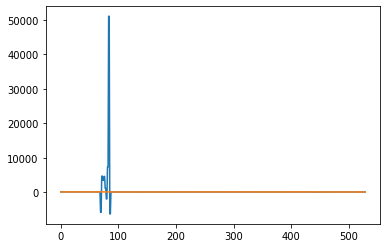

In [350]:
plt.plot(model.predict(X_test))
plt.plot(y_test)

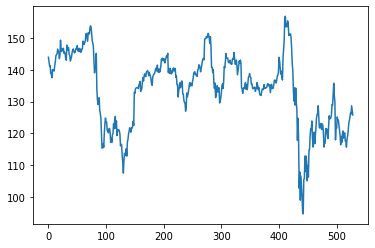

In [351]:
plt.plot(y_test)